In [1]:

from pyspark.sql import SparkSession

#from pyspark.sql.functions import *
spark = SparkSession.builder.master('local').config('spark.driver.memory', '8g').appName(
    'Ready_for_analysis').getOrCreate()



In [2]:

#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)



UsageError: Line magic function `%` not found.


In [3]:
number_of_top_items = '5000'
plot_name = number_of_top_items[0] + 'k'

#print(plot_name)

df = pd.read_pickle(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top5000_seller_YTD_group_by_item_visit_20210607_pre_campaign.pickle')


In [4]:
print(df.dtypes)

min_date                         object
max_date                         object
item_code                        object
item_price                      float64
delivery_weeks                    int64
avg_sales                       float64
avg_unique_views                float64
avg_sessions                    float64
avg_marketing_cost_spend        float64
conv_rate                       float64
bin                               int32
item_parent_item_code            object
item_main_category               object
item_sub_category_1              object
item_sub_category_2              object
log_price                       float64
log_delivery_weeks              float64
log_sales                       float64
log_avg_unique_views            float64
log_conv_rate                   float64
log_avg_sessions                float64
log_avg_marketing_cost_spend    float64
dtype: object


In [5]:
print('Hello world')

Hello world


In [6]:
df.sort_values(by=['max_date'],ascending=False).head()
#print(df['max_date'].nlargest(10))

min_date    max_date           item_code  item_price  \
254487  2021-04-28  2021-04-28  000000001000126024      419.99   
248898  2021-04-21  2021-04-28  000000001000054617      129.99   
248917  2021-04-21  2021-04-28  000000001000133233      129.99   
248923  2021-04-21  2021-04-28  000000001000096837      379.99   
248924  2021-04-21  2021-04-28  000000001000116689       44.99   

        delivery_weeks  avg_sales  avg_unique_views  avg_sessions  \
254487               4      1.000            47.000    16624097.0   
248898              12      0.375            18.500    19887513.0   
248917               3     16.000           538.250    19887513.0   
248923               3      0.125             9.625    19887513.0   
248924               1      5.250           162.875    19887513.0   

        avg_marketing_cost_spend  conv_rate  ...  item_main_category  \
254487             222162.568521   0.021278  ...              BETTEN   
248898             243803.564277   0.020271  ...              WOHNEN   
248917             243803.564277   0.029727  ...              GARTEN   
248923             243803.564277   0.012988  ...                 BAD   
248924             243803.564277   0.032234  ...   SCHLAFZIMMERMÖBEL   

             item_sub_category_1 item_sub_category_2 log_price  \
254487              BETTGESTELLE       POLSTERBETTEN  6.040231   
248898                    TISCHE      BEISTELLTISCHE  4.867458   
248917  KOMPLETTPROGRAMME & SETS     BALKONMÖBELSETS  4.867458   
248923                    BADSET              BADSET  5.940145   
248924             NACHTKOMMODEN       NACHTKOMMODEN  3.806442   

       log_delivery_weeks  log_sales  log_avg_unique_views  log_conv_rate  \
254487           1.386319   0.000100              3.850150      -3.845459   
248898           2.484915  -0.980563              2.917776      -3.893679   
248917           1.098646   2.772595              6.288323      -3.512376   
248923           1.098646  -2.078642              2.264374      -4.336135   
248924           0.000100   1.658247              5.092984      -3.431657   

        log_avg_sessions  log_avg_marketing_cost_spend  
254487         16.626364                     12.311165  
248898         16.805603                     12.404118  
248917         16.805603                     12.404118  
248923         16.805603                     12.404118  
248924         16.805603                     12.404118  

[5 rows x 22 columns]

In [7]:
def filter_df(DF=df, bins=6, avg_PDP=19.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt = df_filt.merge(df_items, on='item_code', how='inner')
    df_filt = df_filt[df_filt['item_price_y'] == True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [8]:
df_filt = filter_df(df)

print(df_filt.item_code.nunique())


4123


In [9]:
df_filt.to_csv('./../raw_data/Excel_files/Top5k_PE_filtered_20210607_pre_campaign.csv')

In [10]:
#introducing the similarity score
sim_score = pd.read_parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-6903f3b3-b5f8-4e2b-a412-a38b179a8b52-c000.snappy.parquet')

In [11]:
sim_score

item_code recommended_item_code  similarity_score
0        000000001000211070    000000001000211156          0.267713
1        000000001000211070    000000001000162020          0.217139
2        000000001000211070    000000001000154918          0.210315
3        000000001000211070    000000001000162102          0.209435
4        000000001000211070    000000001000154842          0.203766
...                     ...                   ...               ...
4396554  000000001000258608    000000001000235287          0.150000
4396555  000000001000258608    000000001000235105          0.150000
4396556  000000001000258608    000000001000258546          0.150000
4396557  000000001000258608    000000001000259368          0.150000
4396558  000000001000258608    000000001000258548          0.150000

[4396559 rows x 3 columns]

In [12]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())

sim_score_filt = sim_score[sim_score['item_code'].isin(unique_item_codes)]

sim_score_filt

item_code recommended_item_code  similarity_score
1280     000000001000008120    000000001000123673          0.802032
1281     000000001000008120    000000001000072324          0.654568
1282     000000001000008120    000000001000121600          0.619514
1283     000000001000008120    000000001000181754          0.576901
1284     000000001000008120    000000001000076799          0.553489
...                     ...                   ...               ...
4395774  000000001000027428    000000001000170712          0.242436
4395775  000000001000027428    000000001000054054          0.238701
4395776  000000001000027428    000000001000236982          0.237533
4395777  000000001000027428    000000001000179045          0.236547
4395778  000000001000027428    000000001000236990          0.229592

[81481 rows x 3 columns]

In [13]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items=unique_item_codes, df=sim_score_filt, score_cut=0.):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['item_code'] == item_code]
        df_score_filt = df_mod[df_mod['similarity_score'] > score_cut]
        final_set_sku = list(df_score_filt.recommended_item_code)
        final_set_sku.insert(0, item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)
    return map_of_items


In [14]:
sim_score_bin = [0.16]  #0.3,0.4,0.5,0.6,0.7,0.8,0.9]




In [15]:
map_of_map_of_items = {}
for sim_score_i in sim_score_bin:
    Map_of_Items = create_map(score_cut=sim_score_i)
    map_of_map_of_items[str(sim_score_i)] = Map_of_Items
#print(map_of_map_of_items)

In [16]:
#load greater dataset
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit_20210607_pre_campaign.pickle'


df_k = pd.read_pickle(largest_dataset)

In [17]:
PDP_bin = [19]  #,30,40,50]

In [18]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP=PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [19]:
def create_map_of_dataframes(items_map=Map_of_Items, df_tmp=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items = items_map[key]
        #print(f'Item_code = {key}')

        df_mod = df_tmp[df_tmp['item_code'].isin(items)]
        #
        #print(f'Number of items per cluster {df_mod.item_code.nunique()}')
        map_of_df[key] = df_mod
    return map_of_df




In [20]:
import numpy as np


def run_model(item_code, df_tmp, map_results, log_session_flag=False, log_marketing_cost=False):
    #print('\n')
    var = ''
    if log_session_flag:
        wls_cr_with_fe = smf.wls("avg_sales ~ log_avg_sessions + log_price + delivery_weeks + C(item_code)", df_tmp,
                                 weights=df_tmp['bin']).fit()
    elif not log_marketing_cost:
        wls_cr_with_fe = smf.wls("avg_sales ~ log_price + delivery_weeks + C(item_code)", df_tmp,
                                 weights=df_tmp['bin']).fit()
    elif log_marketing_cost:
        wls_cr_with_fe = smf.wls("avg_sales ~ log_avg_marketing_cost_spend + log_price + delivery_weeks + C(item_code)",
                                 df_tmp,
                                 weights=df_tmp['bin']).fit()
    wls_cr_with_fe.summary()
    print(wls_cr_with_fe.params)
    print(wls_cr_with_fe.params[0],' ',wls_cr_with_fe.params[-2],' ', wls_cr_with_fe.params[-1])
    intercept, intercept_err = wls_cr_with_fe.params[0].round(4), wls_cr_with_fe.bse[0].round(4)
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4), wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4), wls_cr_with_fe.bse[-1].round(4)
    if log_session_flag == True:
        beta_log_session, beta_std_err_log_session = wls_cr_with_fe.params[-3].round(4), wls_cr_with_fe.bse[-3].round(4)
    if log_marketing_cost == True:
        beta_log_market_cost, beta_std_err_log_market_cost = wls_cr_with_fe.params[-3].round(4), wls_cr_with_fe.bse[
            -3].round(4)
    flag_stat_ok = False
    if beta_log_price != 0:
        flag_stat_ok = np.fabs((3 * beta_std_err_log_price) / beta_log_price) < 1.
    #flag_stat_ok = fabs(beta_std_err_log_price/beta_log_price)
    list_of_result = []
    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)

        if log_session_flag == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_session, beta_std_err_log_session,
                              df_tmp.item_code.nunique(), True]
        elif log_marketing_cost == False:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, df_tmp.item_code.nunique(), True]
        elif log_marketing_cost == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_market_cost, beta_std_err_log_market_cost,
                              df_tmp.item_code.nunique(), True]
        map_results[item_code] = list_of_result
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        if log_session_flag == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_session, beta_std_err_log_session,
                              df_tmp.item_code.nunique(), False]
        elif log_marketing_cost == False:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, df_tmp.item_code.nunique(), False]
        elif log_marketing_cost == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_market_cost, beta_std_err_log_market_cost,
                              df_tmp.item_code.nunique(), False]
        map_results[item_code] = list_of_result
        #print(map_results[item_code])
        return False


In [21]:
def test_session_model(item_code, df_tmp, map_results):
    #print('Starting test model \n')
    wls_cr_with_fe = smf.wls("avg_sales ~ log_avg_sessions + C(item_code) + 0 ", df_tmp, weights=df_tmp['bin']).fit()
    wls_cr_with_fe.summary()
    beta_log_session, beta_std_err_log_session = wls_cr_with_fe.params[-1].round(4), wls_cr_with_fe.bse[-1].round(4)
    intercept, intercept_err = wls_cr_with_fe.params[0].round(4), wls_cr_with_fe.bse[0].round(4)
    flag_stat_ok = False
    if beta_log_session != 0:
        flag_stat_ok = np.fabs((3 * beta_std_err_log_session) / beta_log_session) < 1.
    #flag_stat_ok = fabs(beta_std_err_log_price/beta_log_price)

    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_session, beta_std_err_log_session, intercept, intercept_err,
                                  df_tmp.item_code.nunique(), True]
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_session, beta_std_err_log_session, intercept, intercept_err,
                                  df_tmp.item_code.nunique(), False]
        #print(map_results[item_code])
        return False


In [22]:
#print('Cut on PDP, sim_score, result = ')
def run_clusters(which_model='std', df_cluster=df_PDP_bin_filt, map_items=map_of_map_of_items):
    map_of_maps_of_df = {}

    for PDP_cut in df_cluster.keys():
        for score_cut in map_items.keys():
            map_of_dfs = create_map_of_dataframes(map_items[score_cut], df_tmp=df_PDP_bin_filt[PDP_cut])
            map_of_maps_of_df[PDP_cut] = map_of_dfs
            print(f'Number of items passing the PE cut {len(map_of_dfs)}')
            map_result = {}
            #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
            map_items_stat = {}
            for key in map_of_dfs.keys():
                #map_of_dfs[key].head()
                if which_model == 'std':
                    map_items_stat[key] = run_model(key, map_of_dfs[key], map_result, log_session_flag=False)
                elif which_model == 'std_session':
                    map_items_stat[key] = run_model(key, map_of_dfs[key], map_result, log_session_flag=True)
                elif which_model == 'std_mkt_cost':
                    map_items_stat[key] = run_model(key, map_of_dfs[key], map_result, log_marketing_cost=True)
                elif which_model == 'test':
                    map_items_stat[key] = test_session_model(key, map_of_dfs[key], map_result)
                #print(map_result)
            items_stat_series = pd.Series(map_items_stat)
            #print(map_items_stat)
            #print(items_stat_series)
            x, y, y_err, rel_err = {'True': [], 'False': []}, {'True': [], 'False': []}, {'True': [], 'False': []}, {
                'True': [], 'False': []}
            for i_code, flag in items_stat_series.items():
                #flag=T
                if flag == True:
                    y['True'].append(map_result[i_code][0])
                    y_err['True'].append(map_result[i_code][1])
                    x['True'].append(map_result[i_code][-2])
                    rel_err['True'].append(abs(map_result[i_code][1] / map_result[i_code][0]))

                else:
                    y['False'].append(map_result[i_code][0])
                    y_err['False'].append(map_result[i_code][1])
                    x['False'].append(map_result[i_code][-2])
                    #print('False',map_result[i_code][0],map_result[i_code][1])
                    rel_err['False'].append(abs(map_result[i_code][1] / map_result[i_code][0]))

                    continue
            #print(f'{PDP_cut},{score_cut} , {len(x)}')
        list_of_col_df = []
        if which_model == 'std':
            list_of_col_df = ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err',
                              'intercept', 'intercept_err', 'Cluster_size',
                              'has_enough_stat']
        elif which_model == 'test':
            list_of_col_df = ['log_avg_sessions', 'log_avg_sessions_err', 'Cluster_size', 'intercept', 'intercept_err',
                              'has_enough_stat']
        elif which_model == 'std_session':
            list_of_col_df = ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err',
                              'intercept', 'intercept_err', 'log_avg_sessions', 'log_avg_sessions_err', 'Cluster_size',
                              'has_enough_stat']
        elif which_model == 'std_mkt_cost':
            list_of_col_df = ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err',
                              'intercept', 'intercept_err', 'log_market_cost', 'log_market_cost_err', 'Cluster_size',
                              'has_enough_stat']
        df_result = pd.DataFrame.from_dict(map_result, orient='index',
                                           columns=list_of_col_df)
        print(df_result.head(100))
        return df_result

In [23]:
df_result = run_clusters(which_model='std')


Number of items passing the PE cut 4123
Intercept                             13.532359
C(item_code)[T.000000001000021916]    -0.362104
C(item_code)[T.000000001000021922]     1.540228
C(item_code)[T.000000001000022019]    -1.111680
C(item_code)[T.000000001000047786]     0.590090
C(item_code)[T.000000001000071650]     1.952433
C(item_code)[T.000000001000096836]    -0.442351
C(item_code)[T.000000001000129691]     2.361706
C(item_code)[T.000000001000149111]     1.722050
C(item_code)[T.000000001000158785]     3.007332
C(item_code)[T.000000001000160236]     2.050161
C(item_code)[T.000000001000180824]     1.746080
C(item_code)[T.000000001000205511]     1.025849
C(item_code)[T.000000001000205934]     1.988253
C(item_code)[T.000000001000208980]     0.573105
C(item_code)[T.000000001000209426]     0.095339
C(item_code)[T.000000001000224889]    -1.568783
C(item_code)[T.000000001000227882]    -0.767931
log_price                             -2.716435
delivery_weeks                        -0.061105


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             15.897933
C(item_code)[T.000000001000002471]     0.014755
C(item_code)[T.000000001000110773]     0.933805
C(item_code)[T.000000001000110977]    -1.471714
C(item_code)[T.000000001000111195]    -0.546789
C(item_code)[T.000000001000111475]     1.026471
C(item_code)[T.000000001000128078]     1.239878
C(item_code)[T.000000001000134207]     3.101311
C(item_code)[T.000000001000137512]    -0.230251
C(item_code)[T.000000001000149474]    -0.122329
C(item_code)[T.000000001000157255]     2.582768
C(item_code)[T.000000001000158021]     0.356156
C(item_code)[T.000000001000175476]     2.777021
C(item_code)[T.000000001000182085]     2.889404
C(item_code)[T.000000001000187307]    -1.442805
C(item_code)[T.000000001000188287]    -0.316332
C(item_code)[T.000000001000188289]    -1.367538
C(item_code)[T.000000001000196399]     1.471040
log_price                             -3.458504
delivery_weeks                        -0.149573
dtype: float64
15.897932562363593   -3.4

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                            -0.739804
C(item_code)[T.000000001000034756]    0.020862
C(item_code)[T.000000001000034763]    0.080395
C(item_code)[T.000000001000058377]    0.076881
C(item_code)[T.000000001000058392]    0.370977
C(item_code)[T.000000001000073238]    0.322446
C(item_code)[T.000000001000085417]    0.594606
log_price                             0.151341
delivery_weeks                       -0.020987
dtype: float64
-0.7398037594459999   0.15134144275038744   -0.02098694703928222
Intercept                             2.137325
C(item_code)[T.000000001000021831]    0.021048
C(item_code)[T.000000001000062058]    0.422221
C(item_code)[T.000000001000071034]    0.422730
C(item_code)[T.000000001000071041]    0.076824
C(item_code)[T.000000001000071064]    0.508368
C(item_code)[T.000000001000113331]    0.274629
C(item_code)[T.000000001000119356]   -0.030443
C(item_code)[T.000000001000120600]   -0.050637
C(item_code)[T.000000001000125280]    0.479171
C(item_code)[T.000000001000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             85.129729
C(item_code)[T.000000001000006087]   -21.832876
C(item_code)[T.000000001000006092]   -21.675877
C(item_code)[T.000000001000007431]   -17.671350
C(item_code)[T.000000001000007448]   -13.172487
C(item_code)[T.000000001000015959]   -11.432988
C(item_code)[T.000000001000015990]   -18.447986
C(item_code)[T.000000001000016008]   -16.209897
C(item_code)[T.000000001000016035]   -20.690654
C(item_code)[T.000000001000016110]   -15.827474
C(item_code)[T.000000001000016131]   -15.415718
C(item_code)[T.000000001000016133]    -7.799680
C(item_code)[T.000000001000112662]   -16.880335
C(item_code)[T.000000001000112668]   -16.025496
C(item_code)[T.000000001000116754]   -25.896170
C(item_code)[T.000000001000116755]   -21.530234
C(item_code)[T.000000001000117276]   -13.568096
C(item_code)[T.000000001000178097]   -17.001498
log_price                            -13.511630
delivery_weeks                        -0.241249
dtype: float64
85.12972887275048   -13.5

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             24.509575
C(item_code)[T.000000001000007080]     0.508074
C(item_code)[T.000000001000007105]     2.284875
C(item_code)[T.000000001000022035]    -2.325831
C(item_code)[T.000000001000048005]    -1.258254
C(item_code)[T.000000001000064533]     1.277732
C(item_code)[T.000000001000113296]     0.335456
C(item_code)[T.000000001000119257]    -1.020024
C(item_code)[T.000000001000131866]     1.747526
C(item_code)[T.000000001000134689]    -0.284904
C(item_code)[T.000000001000177711]    -0.631077
C(item_code)[T.000000001000177730]    -1.964191
C(item_code)[T.000000001000201102]    -1.371180
C(item_code)[T.000000001000209210]    -0.811931
C(item_code)[T.000000001000215305]    -0.101836
C(item_code)[T.000000001000226361]    -0.303756
C(item_code)[T.000000001000226372]     0.237195
C(item_code)[T.000000001000228643]    -1.358114
log_price                             -3.822149
delivery_weeks                        -0.009518
dtype: float64
24.50957530872236   -3.82

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.628824
C(item_code)[T.000000001000016094]    0.012823
C(item_code)[T.000000001000016104]   -1.259078
C(item_code)[T.000000001000016121]   -0.166863
C(item_code)[T.000000001000016145]    0.888736
C(item_code)[T.000000001000021610]   -0.619463
C(item_code)[T.000000001000123399]   -0.847568
C(item_code)[T.000000001000123854]   -0.234366
C(item_code)[T.000000001000155630]    0.313520
C(item_code)[T.000000001000183889]   -1.336811
C(item_code)[T.000000001000183890]    0.227076
C(item_code)[T.000000001000183891]    0.382023
C(item_code)[T.000000001000183899]   -1.167262
C(item_code)[T.000000001000189837]   -0.568233
C(item_code)[T.000000001000208717]   -0.231014
log_price                            -1.573433
delivery_weeks                       -0.010652
dtype: float64
9.62882433213871   -1.5734331616679   -0.010652043594433615
Intercept                             2.948489
C(item_code)[T.000000001000068929]    0.091223
C(item_code)[T.00000000100020094

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



18.961434325762212   -3.036536450421941   -0.03288206309451099
Intercept                             13.946648
C(item_code)[T.000000001000081473]    -0.294564
C(item_code)[T.000000001000081478]    -0.159856
C(item_code)[T.000000001000081552]    -0.357450
C(item_code)[T.000000001000081556]     0.502086
C(item_code)[T.000000001000081560]     0.813277
C(item_code)[T.000000001000081602]     0.392661
C(item_code)[T.000000001000084213]    -0.846655
C(item_code)[T.000000001000116689]    -0.197171
C(item_code)[T.000000001000123137]     0.729351
C(item_code)[T.000000001000136755]    -1.008627
C(item_code)[T.000000001000180039]    -1.910151
C(item_code)[T.000000001000211582]    -1.158358
log_price                             -2.836918
delivery_weeks                        -0.030516
dtype: float64
13.946648219762567   -2.8369182924397243   -0.030516467780097263
Intercept                             11.657052
C(item_code)[T.000000001000033448]    -0.099318
C(item_code)[T.000000001000033452]     0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             0.283929
C(item_code)[T.000000001000007534]    0.196347
C(item_code)[T.000000001000014952]    0.149969
C(item_code)[T.000000001000014954]   -0.238754
C(item_code)[T.000000001000015800]    0.086158
C(item_code)[T.000000001000118933]   -0.235886
log_price                            -0.001164
delivery_weeks                       -0.001142
dtype: float64
0.2839294475797267   -0.0011638482037037434   -0.0011421950691874391
Intercept                             16.453914
C(item_code)[T.000000001000007080]     0.366586
C(item_code)[T.000000001000007105]     1.574311
C(item_code)[T.000000001000050887]     0.638221
C(item_code)[T.000000001000113296]     0.331000
C(item_code)[T.000000001000116492]     2.509817
C(item_code)[T.000000001000117155]     1.299380
C(item_code)[T.000000001000123698]    -1.371168
C(item_code)[T.000000001000131866]     1.167780
C(item_code)[T.000000001000150226]     1.279573
C(item_code)[T.000000001000153425]     1.264544
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



9.020798087596564   -1.7463858137133772   -0.04131761754375649
Intercept                             6.334905
C(item_code)[T.000000001000047042]   -1.415584
C(item_code)[T.000000001000065695]   -0.049999
C(item_code)[T.000000001000123535]    1.697676
C(item_code)[T.000000001000152739]    4.788516
C(item_code)[T.000000001000155208]   -1.842287
C(item_code)[T.000000001000164536]    0.309387
C(item_code)[T.000000001000164581]   -0.803685
C(item_code)[T.000000001000164792]   -1.102214
log_price                            -0.692675
delivery_weeks                       -0.387908
dtype: float64
6.33490456602714   -0.6926752280295913   -0.3879076948159563
Intercept                             7.273440
C(item_code)[T.000000001000008754]    1.281418
C(item_code)[T.000000001000008815]    0.136111
C(item_code)[T.000000001000039131]   -0.148765
C(item_code)[T.000000001000050876]    0.503020
C(item_code)[T.000000001000114992]   -0.442613
C(item_code)[T.000000001000117156]    0.319946
C(item_code)[T

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             3.808088
C(item_code)[T.000000001000076730]   -0.461332
C(item_code)[T.000000001000076754]   -0.379220
C(item_code)[T.000000001000080373]   -0.155482
C(item_code)[T.000000001000080376]    0.681801
C(item_code)[T.000000001000113321]   -0.255784
C(item_code)[T.000000001000120528]   -0.419860
C(item_code)[T.000000001000133170]   -0.098752
C(item_code)[T.000000001000133205]   -0.346260
C(item_code)[T.000000001000154624]   -0.453755
C(item_code)[T.000000001000194670]   -0.463024
C(item_code)[T.000000001000212372]   -0.528762
C(item_code)[T.000000001000212386]   -0.451359
C(item_code)[T.000000001000212389]   -0.354365
C(item_code)[T.000000001000214951]   -0.444221
log_price                            -0.502116
delivery_weeks                       -0.010790
dtype: float64
3.8080884499154752   -0.5021156958296651   -0.010789864906731386
Intercept         27.455808
log_price         -6.235816
delivery_weeks    -0.029141
dtype: float64
27.455808101379766   -

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:762: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(SSR) * nobs2      # concentrated likelihood
/Users/gabr

Intercept                             23.136107
C(item_code)[T.000000001000015760]    -3.786060
C(item_code)[T.000000001000015926]    -1.020758
C(item_code)[T.000000001000064649]    -2.410855
C(item_code)[T.000000001000095038]    -1.924967
C(item_code)[T.000000001000119837]    -2.263773
C(item_code)[T.000000001000125869]    -3.193435
C(item_code)[T.000000001000126126]    -3.657438
C(item_code)[T.000000001000138993]    -5.139106
C(item_code)[T.000000001000174090]    -0.207296
C(item_code)[T.000000001000174104]    -4.562229
C(item_code)[T.000000001000174107]    -2.683324
C(item_code)[T.000000001000183892]    -1.699184
C(item_code)[T.000000001000209645]    -1.481279
C(item_code)[T.000000001000209649]    -3.446390
C(item_code)[T.000000001000209681]    -2.832336
log_price                             -3.749789
delivery_weeks                        -0.046980
dtype: float64
23.136107353514394   -3.749789177235193   -0.046980211028725544
Intercept                             11.487665
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                            -0.001216
C(item_code)[T.000000001000024473]    0.357491
C(item_code)[T.000000001000024942]    0.228150
C(item_code)[T.000000001000024948]    0.282237
C(item_code)[T.000000001000025075]    0.139016
C(item_code)[T.000000001000038330]   -0.020642
C(item_code)[T.000000001000091288]    0.010720
C(item_code)[T.000000001000092561]    0.214330
C(item_code)[T.000000001000117372]   -0.047786
C(item_code)[T.000000001000125180]   -0.127981
log_price                             0.035923
delivery_weeks                       -0.013735
dtype: float64
-0.0012158754100450864   0.0359233580247863   -0.013734990802679892
Intercept                             5.512533
C(item_code)[T.000000001000038724]    0.194095
C(item_code)[T.000000001000062038]    0.955478
C(item_code)[T.000000001000071065]    0.836399
C(item_code)[T.000000001000071071]    0.241095
C(item_code)[T.000000001000113344]    0.626014
C(item_code)[T.000000001000119375]    0.281071
C(item_code)[T.000000001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             1.700854
C(item_code)[T.000000001000047042]   -0.027874
C(item_code)[T.000000001000050766]    0.125695
C(item_code)[T.000000001000065733]    0.551981
C(item_code)[T.000000001000065873]   -0.621697
C(item_code)[T.000000001000152739]    5.212338
C(item_code)[T.000000001000164581]   -0.134733
C(item_code)[T.000000001000164792]   -0.611218
C(item_code)[T.000000001000165493]   -0.672642
C(item_code)[T.000000001000165494]    0.059013
C(item_code)[T.000000001000165495]   -0.351291
C(item_code)[T.000000001000179706]    0.223107
log_price                            -0.101534
delivery_weeks                       -0.138011
dtype: float64
1.700854427542465   -0.10153419654260232   -0.1380110997253412
Intercept                             21.916498
C(item_code)[T.000000001000006093]    -0.222502
C(item_code)[T.000000001000015677]    -0.625025
C(item_code)[T.000000001000016010]     0.889141
C(item_code)[T.000000001000116754]    -2.371179
C(item_code)[T.000000001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



10.127109164019913   -1.666729114949655   -0.01962344761406025
Intercept                             12.023590
C(item_code)[T.000000001000111018]    -1.836507
C(item_code)[T.000000001000111075]     1.086796
C(item_code)[T.000000001000111083]     1.305888
C(item_code)[T.000000001000117699]     4.048189
C(item_code)[T.000000001000129416]     4.219165
C(item_code)[T.000000001000130658]     1.774984
C(item_code)[T.000000001000153558]     2.500545
C(item_code)[T.000000001000157002]     3.855600
C(item_code)[T.000000001000157254]     1.154266
C(item_code)[T.000000001000160324]     1.197904
C(item_code)[T.000000001000178362]     4.066893
C(item_code)[T.000000001000182117]     2.777405
C(item_code)[T.000000001000188466]     1.722376
C(item_code)[T.000000001000188574]     1.907434
C(item_code)[T.000000001000216583]     3.511638
log_price                             -3.038301
delivery_weeks                        -0.109992
dtype: float64
12.023589739361892   -3.038301141500839   -0.109991619819

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             26.921647
C(item_code)[T.000000001000007429]     0.457944
C(item_code)[T.000000001000007446]     1.697469
C(item_code)[T.000000001000015991]     1.842614
C(item_code)[T.000000001000016001]     2.097652
C(item_code)[T.000000001000016013]     3.400504
C(item_code)[T.000000001000016023]     4.324079
C(item_code)[T.000000001000016025]     1.392090
C(item_code)[T.000000001000016096]     3.082222
C(item_code)[T.000000001000016133]    13.150399
C(item_code)[T.000000001000016139]     7.235876
C(item_code)[T.000000001000040294]     4.135118
C(item_code)[T.000000001000123390]     4.637025
C(item_code)[T.000000001000123815]     1.726077
C(item_code)[T.000000001000138433]     2.612598
C(item_code)[T.000000001000164525]     0.587103
C(item_code)[T.000000001000176578]     3.632953
C(item_code)[T.000000001000176715]     2.516795
C(item_code)[T.000000001000183898]     2.752523
C(item_code)[T.000000001000184191]     0.336020
C(item_code)[T.000000001000216195]     5

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             11.632412
C(item_code)[T.000000001000087612]     0.371050
C(item_code)[T.000000001000120669]    -0.151535
C(item_code)[T.000000001000121204]    -1.466265
C(item_code)[T.000000001000152007]    -0.319799
C(item_code)[T.000000001000152009]    -0.003808
C(item_code)[T.000000001000153587]     1.475690
C(item_code)[T.000000001000180487]    -0.591234
C(item_code)[T.000000001000188242]    -1.150773
C(item_code)[T.000000001000192637]    -0.470709
C(item_code)[T.000000001000195868]    -0.045875
C(item_code)[T.000000001000198997]    -0.363743
C(item_code)[T.000000001000206737]    -0.440728
C(item_code)[T.000000001000208500]     0.479643
C(item_code)[T.000000001000208890]    -0.619392
log_price                             -2.060358
delivery_weeks                        -0.040375
dtype: float64
11.632411891767433   -2.060357886858265   -0.040375070982081485
Intercept                             9.530126
C(item_code)[T.000000001000005772]   -1.556110
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             6.211666
C(item_code)[T.000000001000005398]   -0.085242
C(item_code)[T.000000001000007405]   -0.866203
C(item_code)[T.000000001000015581]   -1.354958
C(item_code)[T.000000001000015721]   -0.728528
C(item_code)[T.000000001000110756]   -0.803875
C(item_code)[T.000000001000120296]   -1.236679
C(item_code)[T.000000001000124047]   -0.647162
C(item_code)[T.000000001000124998]   -0.483799
C(item_code)[T.000000001000162498]   -1.020290
C(item_code)[T.000000001000172237]   -0.719558
C(item_code)[T.000000001000175533]   -0.866555
C(item_code)[T.000000001000214919]   -0.607474
log_price                            -0.826593
delivery_weeks                       -0.021643
dtype: float64
6.211665981687853   -0.8265932506144451   -0.021643096488587837
Intercept                             12.950317
C(item_code)[T.000000001000071650]     0.251946
C(item_code)[T.000000001000087163]    -1.381862
C(item_code)[T.000000001000125852]     0.523466
C(item_code)[T.000000001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



7.301033937618038   -0.9089665943032953   -0.14303204839825595
Intercept                             1.422925
C(item_code)[T.000000001000015741]    0.726055
C(item_code)[T.000000001000124123]    0.041904
C(item_code)[T.000000001000147134]    0.454445
C(item_code)[T.000000001000152399]    0.648052
C(item_code)[T.000000001000166820]   -0.100578
C(item_code)[T.000000001000209686]    0.158202
C(item_code)[T.000000001000213935]   -0.052081
C(item_code)[T.000000001000226106]    0.649615
C(item_code)[T.000000001000226422]    0.686777
C(item_code)[T.000000001000229701]    0.980245
log_price                            -0.234275
delivery_weeks                       -0.062157
dtype: float64
1.4229253294107473   -0.23427466890398507   -0.06215675101625313
Intercept                             9.902872
C(item_code)[T.000000001000021921]   -0.223819
C(item_code)[T.000000001000021927]   -0.736918
C(item_code)[T.000000001000021941]   -0.511221
C(item_code)[T.000000001000022018]   -0.981037
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             12.682938
C(item_code)[T.000000001000104114]     0.274789
C(item_code)[T.000000001000117186]     0.623604
C(item_code)[T.000000001000117192]     0.955003
C(item_code)[T.000000001000118144]    -0.247364
C(item_code)[T.000000001000118162]    -1.548078
C(item_code)[T.000000001000123454]    -1.414028
C(item_code)[T.000000001000123455]    -1.764256
C(item_code)[T.000000001000145195]    -1.029258
C(item_code)[T.000000001000145315]    -1.398215
C(item_code)[T.000000001000150213]    -0.429423
C(item_code)[T.000000001000151787]    -2.284373
C(item_code)[T.000000001000166037]    -0.818296
C(item_code)[T.000000001000166789]    -0.695438
C(item_code)[T.000000001000178729]    -0.736686
C(item_code)[T.000000001000211528]    -1.031975
C(item_code)[T.000000001000212383]    -1.445253
log_price                             -2.345434
delivery_weeks                        -0.025997
dtype: float64
12.682938101729466   -2.345433842009215   -0.02599702176127654
Intercept 

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             0.317404
C(item_code)[T.000000001000031150]    0.072366
C(item_code)[T.000000001000034531]    0.086497
C(item_code)[T.000000001000034542]   -0.049289
C(item_code)[T.000000001000034647]   -0.075935
C(item_code)[T.000000001000034750]   -0.019277
C(item_code)[T.000000001000034763]    0.061570
C(item_code)[T.000000001000058401]   -0.029999
C(item_code)[T.000000001000083965]   -0.080685
log_price                            -0.022378
delivery_weeks                       -0.006371
dtype: float64
0.3174040181531901   -0.022377593887906236   -0.006370883211736037
Intercept                             20.084840
C(item_code)[T.000000001000052286]    -3.261060
C(item_code)[T.000000001000052292]    -2.811506
C(item_code)[T.000000001000052299]    -1.790110
C(item_code)[T.000000001000052304]    -3.221527
C(item_code)[T.000000001000052438]    -2.827448
C(item_code)[T.000000001000098554]     0.978820
C(item_code)[T.000000001000122984]     0.206216
C(item_code)[T.00

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             5.380593
C(item_code)[T.000000001000071068]    0.233001
C(item_code)[T.000000001000113354]    0.226902
C(item_code)[T.000000001000125281]    0.392146
C(item_code)[T.000000001000129959]    0.185616
C(item_code)[T.000000001000149852]    0.200445
C(item_code)[T.000000001000199676]    0.126587
log_price                            -0.765485
delivery_weeks                       -0.004237
dtype: float64
5.380592593763071   -0.7654849342757319   -0.004236566234871194
Intercept                             35.069151
C(item_code)[T.000000001000007431]     3.216299
C(item_code)[T.000000001000007435]     0.539786
C(item_code)[T.000000001000015962]     4.248272
C(item_code)[T.000000001000015991]     1.030474
C(item_code)[T.000000001000016020]     7.431862
C(item_code)[T.000000001000016023]     3.531018
C(item_code)[T.000000001000016112]     1.879982
C(item_code)[T.000000001000016131]     3.818227
C(item_code)[T.000000001000040294]     3.772006
C(item_code)[T.000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             17.639472
C(item_code)[T.000000001000008870]     0.019255
C(item_code)[T.000000001000008872]    -0.550854
C(item_code)[T.000000001000039138]    -0.598721
C(item_code)[T.000000001000050847]    -1.177242
C(item_code)[T.000000001000063660]    -1.121543
C(item_code)[T.000000001000079727]    -2.696415
C(item_code)[T.000000001000123082]    -3.148719
C(item_code)[T.000000001000150447]    -0.121301
C(item_code)[T.000000001000168496]    -1.945005
C(item_code)[T.000000001000204356]    -1.686367
C(item_code)[T.000000001000214327]    -0.159173
log_price                             -2.698004
delivery_weeks                        -0.042833
dtype: float64
17.639471845264282   -2.6980036351471384   -0.04283280162468503
Intercept                             15.446855
C(item_code)[T.000000001000076408]     0.287509
C(item_code)[T.000000001000076599]    -1.762482
C(item_code)[T.000000001000076608]    -1.282532
C(item_code)[T.000000001000076619]    -1.255268
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



16.83789114666184   -2.2220194677378835   -0.0016444066152754688
Intercept                             27.530712
C(item_code)[T.000000001000016116]    -1.775915
C(item_code)[T.000000001000016140]    -1.507850
C(item_code)[T.000000001000114113]    -2.438686
C(item_code)[T.000000001000123330]    -1.264970
C(item_code)[T.000000001000123758]    -1.295549
C(item_code)[T.000000001000125113]    -0.395767
C(item_code)[T.000000001000159236]    -3.588448
C(item_code)[T.000000001000171133]    -3.115593
C(item_code)[T.000000001000176441]    -2.595900
C(item_code)[T.000000001000176706]    -2.433175
C(item_code)[T.000000001000176712]    -3.303377
C(item_code)[T.000000001000176715]    -3.009581
C(item_code)[T.000000001000176717]    -2.935640
C(item_code)[T.000000001000183898]    -2.815937
log_price                             -4.761591
delivery_weeks                        -0.067947
dtype: float64
27.530712201022926   -4.761591435550095   -0.06794737423711585
Intercept                             5.

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             2.087833
C(item_code)[T.000000001000084229]   -0.148895
C(item_code)[T.000000001000084250]   -0.143790
C(item_code)[T.000000001000084287]   -0.219144
C(item_code)[T.000000001000092058]   -0.490969
C(item_code)[T.000000001000092075]   -0.424694
C(item_code)[T.000000001000104278]   -0.453214
C(item_code)[T.000000001000104279]   -0.405368
C(item_code)[T.000000001000123644]   -0.284435
C(item_code)[T.000000001000123648]   -0.219406
C(item_code)[T.000000001000136062]   -0.231929
C(item_code)[T.000000001000147263]   -0.501115
C(item_code)[T.000000001000180132]   -0.443432
C(item_code)[T.000000001000181290]   -0.622679
C(item_code)[T.000000001000213895]   -0.611491
log_price                            -0.251426
delivery_weeks                        0.001279
dtype: float64
2.0878327422542142   -0.2514258450760628   0.0012791754832050975
Intercept                             11.221351
C(item_code)[T.000000001000007573]     0.280526
C(item_code)[T.0000000010

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             6.056850
C(item_code)[T.000000001000008078]    1.061560
C(item_code)[T.000000001000039430]   -0.485105
C(item_code)[T.000000001000039432]   -1.332182
C(item_code)[T.000000001000039513]   -0.484225
C(item_code)[T.000000001000048010]   -0.110053
C(item_code)[T.000000001000064337]   -0.057729
C(item_code)[T.000000001000064348]   -0.626129
C(item_code)[T.000000001000119939]    0.797290
C(item_code)[T.000000001000126213]   -0.005828
C(item_code)[T.000000001000126222]   -0.853340
C(item_code)[T.000000001000126840]   -0.693958
C(item_code)[T.000000001000166817]   -0.308049
C(item_code)[T.000000001000166818]   -0.554816
C(item_code)[T.000000001000183576]   -0.584282
C(item_code)[T.000000001000191489]   -0.185235
log_price                            -0.906710
delivery_weeks                       -0.025026
dtype: float64
6.056849523863899   -0.9067098014873777   -0.02502610007345268
Intercept                             15.571764
C(item_code)[T.0000000010000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             18.939500
C(item_code)[T.000000001000015711]    -0.541245
C(item_code)[T.000000001000015739]    -3.963842
C(item_code)[T.000000001000015741]    -0.240375
C(item_code)[T.000000001000015909]    -2.192966
C(item_code)[T.000000001000226106]    -4.476766
log_price                             -3.919759
delivery_weeks                        -0.065499
dtype: float64
18.93949973910871   -3.9197585578304226   -0.06549875956642415
Intercept                             10.227756
C(item_code)[T.000000001000016039]    -0.012402
C(item_code)[T.000000001000053481]     1.856331
C(item_code)[T.000000001000057300]     0.596874
C(item_code)[T.000000001000060756]     0.614162
C(item_code)[T.000000001000071068]     1.861787
C(item_code)[T.000000001000119358]     2.052151
C(item_code)[T.000000001000119666]     0.359675
C(item_code)[T.000000001000123591]     0.085170
C(item_code)[T.000000001000126027]     0.761456
C(item_code)[T.000000001000127446]    -0.244881
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             55.788413
C(item_code)[T.000000001000022466]     0.020748
C(item_code)[T.000000001000022482]    -1.465509
C(item_code)[T.000000001000022497]    -0.794321
C(item_code)[T.000000001000022562]    -0.354990
C(item_code)[T.000000001000022568]     5.855532
C(item_code)[T.000000001000022573]     0.683225
C(item_code)[T.000000001000022607]     5.225762
C(item_code)[T.000000001000022615]   -14.890086
C(item_code)[T.000000001000022708]    -0.743593
C(item_code)[T.000000001000022709]    -3.555103
C(item_code)[T.000000001000175647]    -6.768319
C(item_code)[T.000000001000188579]   -10.499248
log_price                            -10.681701
delivery_weeks                        -0.195116
dtype: float64
55.78841346855987   -10.681700659753552   -0.19511616748692145
Intercept                             9.645645
C(item_code)[T.000000001000027423]   -0.263056
C(item_code)[T.000000001000053260]   -0.678712
C(item_code)[T.000000001000104454]    0.779628
C(item_code)[T

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.354718
C(item_code)[T.000000001000021845]    -0.170414
C(item_code)[T.000000001000024351]    -0.919597
C(item_code)[T.000000001000062041]     0.027405
C(item_code)[T.000000001000071036]    -0.275991
C(item_code)[T.000000001000071068]    -0.242738
C(item_code)[T.000000001000113346]    -0.954744
C(item_code)[T.000000001000179074]    -0.279556
log_price                             -1.528939
delivery_weeks                        -0.021951
dtype: float64
11.354718226789036   -1.528939249365406   -0.021950984521537164
Intercept         18.026586
log_price         -4.210169
delivery_weeks     0.051442
dtype: float64
18.026586184331634   -4.210168786974437   0.051442453143880865
Intercept                             12.889536
C(item_code)[T.000000001000091519]    -1.647709
C(item_code)[T.000000001000091532]    -1.205860
C(item_code)[T.000000001000091560]    -1.390202
C(item_code)[T.000000001000131866]    -0.148922
C(item_code)[T.000000001000150711]    -

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             6.304383
C(item_code)[T.000000001000071072]   -0.306072
C(item_code)[T.000000001000119375]   -0.502772
C(item_code)[T.000000001000129972]   -0.360802
C(item_code)[T.000000001000143707]   -0.516217
C(item_code)[T.000000001000174150]   -0.368757
C(item_code)[T.000000001000175765]   -0.424333
C(item_code)[T.000000001000175855]   -0.112154
C(item_code)[T.000000001000179073]   -0.343819
C(item_code)[T.000000001000179076]   -0.521377
C(item_code)[T.000000001000199713]   -0.555791
C(item_code)[T.000000001000200211]   -0.522094
C(item_code)[T.000000001000201653]   -0.247392
C(item_code)[T.000000001000208294]   -0.433154
log_price                            -0.832347
delivery_weeks                       -0.007669
dtype: float64
6.304383367944034   -0.8323474763467347   -0.007668783142383329
Intercept                             32.932479
C(item_code)[T.000000001000054049]     2.717679
C(item_code)[T.000000001000167293]     0.881509
C(item_code)[T.0000000010

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             16.684590
C(item_code)[T.000000001000063647]     1.783081
C(item_code)[T.000000001000064495]     3.718601
C(item_code)[T.000000001000084099]    -0.350640
C(item_code)[T.000000001000151924]     1.174728
C(item_code)[T.000000001000169170]     0.504454
C(item_code)[T.000000001000169679]     1.064347
C(item_code)[T.000000001000171100]     0.556370
C(item_code)[T.000000001000174248]     0.041869
C(item_code)[T.000000001000176434]     0.309997
C(item_code)[T.000000001000179052]     3.790330
C(item_code)[T.000000001000183808]     0.254346
C(item_code)[T.000000001000184864]    -0.257017
log_price                             -3.278645
delivery_weeks                        -0.039297
dtype: float64
16.684590108325466   -3.278644968269364   -0.03929736739325303
Intercept                             16.774818
C(item_code)[T.000000001000005827]    -0.183566
C(item_code)[T.000000001000005829]     0.398145
C(item_code)[T.000000001000005836]     2.904744
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             0.987082
C(item_code)[T.000000001000016137]    0.403068
C(item_code)[T.000000001000035445]    0.330542
C(item_code)[T.000000001000035472]    0.415323
C(item_code)[T.000000001000113520]    0.720077
C(item_code)[T.000000001000129054]    0.569932
C(item_code)[T.000000001000162734]    0.275117
C(item_code)[T.000000001000169156]    0.187830
C(item_code)[T.000000001000176721]    0.772064
C(item_code)[T.000000001000176727]    0.052336
C(item_code)[T.000000001000176737]    0.005200
C(item_code)[T.000000001000196340]    0.123216
C(item_code)[T.000000001000210733]    0.364333
log_price                            -0.128744
delivery_weeks                       -0.027534
dtype: float64
0.9870823566544988   -0.1287440302882792   -0.02753421437846951
Intercept                             16.825557
C(item_code)[T.000000001000096428]     1.427047
C(item_code)[T.000000001000168550]     0.337193
C(item_code)[T.000000001000168551]    -0.272278
C(item_code)[T.000000001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             5.584964
C(item_code)[T.000000001000034764]    0.081217
C(item_code)[T.000000001000058376]    0.185810
C(item_code)[T.000000001000058396]    0.026675
C(item_code)[T.000000001000073173]   -0.179632
C(item_code)[T.000000001000073197]   -0.048449
C(item_code)[T.000000001000086554]    0.189836
log_price                            -0.856767
delivery_weeks                       -0.023463
dtype: float64
5.584963863835777   -0.8567670276359425   -0.023463032092715396
Intercept                             6.678174
C(item_code)[T.000000001000076600]   -0.658162
C(item_code)[T.000000001000076603]   -1.195876
C(item_code)[T.000000001000076608]   -1.002005
C(item_code)[T.000000001000076622]   -1.070326
C(item_code)[T.000000001000079664]   -1.309441
C(item_code)[T.000000001000080290]   -0.360013
C(item_code)[T.000000001000080490]   -0.689269
C(item_code)[T.000000001000081624]   -1.203298
C(item_code)[T.000000001000081676]   -1.282905
C(item_code)[T.0000000010000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             12.456327
C(item_code)[T.000000001000092426]     1.352296
C(item_code)[T.000000001000113632]    -0.791368
C(item_code)[T.000000001000113639]    -0.156459
C(item_code)[T.000000001000121059]    -1.030790
C(item_code)[T.000000001000128078]    -0.295122
C(item_code)[T.000000001000129442]    -0.073546
C(item_code)[T.000000001000146653]     0.826371
C(item_code)[T.000000001000149139]     0.107419
C(item_code)[T.000000001000149268]    -0.687022
C(item_code)[T.000000001000149323]    -0.636684
C(item_code)[T.000000001000149332]    -1.967263
C(item_code)[T.000000001000175476]     1.089248
C(item_code)[T.000000001000182876]     0.408421
C(item_code)[T.000000001000187388]    -0.950052
C(item_code)[T.000000001000219654]     0.198427
C(item_code)[T.000000001000228706]    -0.580663
log_price                             -2.398510
delivery_weeks                         0.067688
dtype: float64
12.456327010856711   -2.3985095810340495   0.06768825267746659
Intercept 

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             20.426768
C(item_code)[T.000000001000008867]     2.313724
C(item_code)[T.000000001000008872]     1.165398
C(item_code)[T.000000001000039137]     0.861468
C(item_code)[T.000000001000040399]     0.184335
C(item_code)[T.000000001000050847]     0.726006
C(item_code)[T.000000001000050880]    -3.989454
C(item_code)[T.000000001000050881]    -1.547570
C(item_code)[T.000000001000123250]    -0.173487
C(item_code)[T.000000001000123494]     0.869992
C(item_code)[T.000000001000125845]    -0.052468
C(item_code)[T.000000001000149752]     0.108600
C(item_code)[T.000000001000178069]    -0.063788
C(item_code)[T.000000001000179342]    -4.034129
C(item_code)[T.000000001000204356]    -0.033199
log_price                             -3.505337
delivery_weeks                        -0.029282
dtype: float64
20.426768029965586   -3.5053368883920264   -0.029281752166169198
Intercept                             1.531168
C(item_code)[T.000000001000007361]    0.054062
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             19.693446
C(item_code)[T.000000001000015837]    -0.667962
C(item_code)[T.000000001000016195]     0.295219
C(item_code)[T.000000001000016196]    -0.613213
C(item_code)[T.000000001000050958]     2.735111
C(item_code)[T.000000001000116893]     0.628362
C(item_code)[T.000000001000118980]     1.056660
C(item_code)[T.000000001000131165]     0.008815
C(item_code)[T.000000001000179436]     4.621014
C(item_code)[T.000000001000183832]    -1.670037
C(item_code)[T.000000001000183926]    -0.338698
C(item_code)[T.000000001000183932]    -0.341156
C(item_code)[T.000000001000183933]    -0.262509
C(item_code)[T.000000001000183944]     1.131551
C(item_code)[T.000000001000183947]     2.051975
log_price                             -3.715622
delivery_weeks                        -0.028095
dtype: float64
19.693445813412428   -3.7156216786237724   -0.028095419113733425
Intercept                             6.687009
C(item_code)[T.000000001000008758]    0.306505
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             18.218654
C(item_code)[T.000000001000027400]     1.862793
C(item_code)[T.000000001000046703]     1.042143
C(item_code)[T.000000001000064494]     4.294247
C(item_code)[T.000000001000129679]     3.995787
C(item_code)[T.000000001000169167]     3.022150
C(item_code)[T.000000001000169170]     1.434764
C(item_code)[T.000000001000169679]     2.006647
C(item_code)[T.000000001000171065]     0.651262
C(item_code)[T.000000001000171100]     1.548008
C(item_code)[T.000000001000171117]     2.147945
C(item_code)[T.000000001000176442]     0.900655
C(item_code)[T.000000001000188888]     1.930984
log_price                             -3.767794
delivery_weeks                        -0.032828
dtype: float64
18.21865423214586   -3.7677936237836303   -0.03282755213480389
Intercept                             27.431235
C(item_code)[T.000000001000007107]     1.619841
C(item_code)[T.000000001000007108]     1.227553
C(item_code)[T.000000001000008813]     1.631361
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.306193
C(item_code)[T.000000001000104360]   -0.701039
C(item_code)[T.000000001000125638]   -0.528786
C(item_code)[T.000000001000132094]   -1.356558
C(item_code)[T.000000001000134760]   -0.280421
C(item_code)[T.000000001000178074]   -1.087159
C(item_code)[T.000000001000183877]   -0.769800
log_price                            -1.308224
delivery_weeks                       -0.010564
dtype: float64
9.306192724041278   -1.308224059461596   -0.01056403917051029
Intercept                             1.518259
C(item_code)[T.000000001000086506]    0.235333
C(item_code)[T.000000001000118253]   -0.199648
C(item_code)[T.000000001000118279]   -0.205602
C(item_code)[T.000000001000126203]    1.492434
C(item_code)[T.000000001000127674]    0.070007
C(item_code)[T.000000001000129063]    0.024836
C(item_code)[T.000000001000166220]   -0.111316
C(item_code)[T.000000001000166865]   -0.061690
C(item_code)[T.000000001000174665]   -0.143030
C(item_code)[T.000000001000182

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             6.719978
C(item_code)[T.000000001000113280]   -0.759202
C(item_code)[T.000000001000119364]   -0.874223
C(item_code)[T.000000001000119376]   -0.709848
C(item_code)[T.000000001000176461]   -1.248530
C(item_code)[T.000000001000199681]   -0.573483
C(item_code)[T.000000001000199682]   -0.757635
C(item_code)[T.000000001000199712]   -0.388545
C(item_code)[T.000000001000200182]   -0.724456
C(item_code)[T.000000001000200184]   -0.742612
C(item_code)[T.000000001000208288]   -0.673390
log_price                            -0.868964
delivery_weeks                       -0.004915
dtype: float64
6.719978325823452   -0.8689636421270519   -0.00491509470763859
Intercept                             15.789303
C(item_code)[T.000000001000007436]    -0.703407
C(item_code)[T.000000001000016023]     1.942735
C(item_code)[T.000000001000016139]     3.884459
C(item_code)[T.000000001000054419]     1.344559
C(item_code)[T.000000001000054424]     1.205168
C(item_code)[T.00000000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             16.131388
C(item_code)[T.000000001000022053]     1.147575
C(item_code)[T.000000001000046262]     1.294088
C(item_code)[T.000000001000046288]    -0.169324
C(item_code)[T.000000001000051361]     1.531681
C(item_code)[T.000000001000122087]     1.644874
C(item_code)[T.000000001000131856]     3.641160
C(item_code)[T.000000001000171335]     2.926859
C(item_code)[T.000000001000171354]     2.034889
C(item_code)[T.000000001000205080]     0.837350
C(item_code)[T.000000001000216291]     1.264523
C(item_code)[T.000000001000224390]     0.918073
C(item_code)[T.000000001000224469]     1.693940
C(item_code)[T.000000001000226257]     1.786928
log_price                             -2.679991
delivery_weeks                        -0.016114
dtype: float64
16.131387986528523   -2.6799913523422187   -0.016113959579045056
Intercept                             0.203241
C(item_code)[T.000000001000131867]   -0.121406
C(item_code)[T.000000001000166135]   -0.127581
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             4.519712
C(item_code)[T.000000001000152768]   -0.676858
C(item_code)[T.000000001000165482]   -0.531067
C(item_code)[T.000000001000178647]   -0.230820
C(item_code)[T.000000001000191226]    0.015863
C(item_code)[T.000000001000191240]   -0.041261
log_price                            -0.602585
delivery_weeks                       -0.010900
dtype: float64
4.519712327455886   -0.6025850540038392   -0.010900140774529688
Intercept                             0.984282
C(item_code)[T.000000001000051410]    0.028221
C(item_code)[T.000000001000052653]   -0.078816
C(item_code)[T.000000001000056766]   -0.082616
C(item_code)[T.000000001000056771]   -0.086031
C(item_code)[T.000000001000084258]    0.098144
C(item_code)[T.000000001000092060]   -0.110707
C(item_code)[T.000000001000104347]   -0.025422
C(item_code)[T.000000001000136064]   -0.033910
C(item_code)[T.000000001000136093]   -0.040815
C(item_code)[T.000000001000136095]   -0.012864
C(item_code)[T.0000000010002

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             18.806460
C(item_code)[T.000000001000029525]    -2.220385
C(item_code)[T.000000001000051547]    -1.518728
C(item_code)[T.000000001000113247]    -2.183198
C(item_code)[T.000000001000127680]    -1.326236
C(item_code)[T.000000001000131100]    -2.178228
C(item_code)[T.000000001000136739]    -2.389442
C(item_code)[T.000000001000148179]    -2.309690
C(item_code)[T.000000001000183420]    -1.379206
C(item_code)[T.000000001000189384]    -2.269337
C(item_code)[T.000000001000222141]    -1.907798
log_price                             -2.290361
delivery_weeks                        -0.008950
dtype: float64
18.80645969492976   -2.2903611294831396   -0.008949739532712352
Intercept                             0.795656
C(item_code)[T.000000001000015496]    1.842480
C(item_code)[T.000000001000127490]    0.253125
C(item_code)[T.000000001000179416]    0.047892
C(item_code)[T.000000001000180893]   -0.045457
C(item_code)[T.000000001000186218]    0.449754
log_price      

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             4.703445
C(item_code)[T.000000001000123444]    0.362237
C(item_code)[T.000000001000135275]   -0.072306
C(item_code)[T.000000001000148081]    0.897874
C(item_code)[T.000000001000159187]    0.898266
C(item_code)[T.000000001000168917]    0.205272
C(item_code)[T.000000001000184275]    0.506746
C(item_code)[T.000000001000184631]    0.307613
C(item_code)[T.000000001000188135]    0.523753
C(item_code)[T.000000001000227889]    0.414942
log_price                            -0.934351
delivery_weeks                       -0.021939
dtype: float64
4.70344512924813   -0.9343509344533567   -0.021939491121281445
Intercept                            -0.371596
C(item_code)[T.000000001000216694]    0.067835
C(item_code)[T.000000001000216719]    0.080972
log_price                             0.083221
delivery_weeks                       -0.014241
dtype: float64
-0.3715960834358456   0.08322083012325304   -0.014241454633733315
Intercept                             7.27

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             4.889247
C(item_code)[T.000000001000030932]   -1.853920
C(item_code)[T.000000001000030963]   -1.954571
C(item_code)[T.000000001000085210]   -1.838670
C(item_code)[T.000000001000086547]   -1.621346
C(item_code)[T.000000001000094670]   -1.178937
C(item_code)[T.000000001000113432]   -0.732178
C(item_code)[T.000000001000119220]   -2.022870
C(item_code)[T.000000001000119239]   -1.783180
C(item_code)[T.000000001000119241]   -1.914482
C(item_code)[T.000000001000119243]   -1.837952
C(item_code)[T.000000001000119248]   -1.935480
C(item_code)[T.000000001000119265]   -1.626867
C(item_code)[T.000000001000198242]   -0.833594
log_price                            -0.424694
delivery_weeks                       -0.022776
dtype: float64
4.88924693594593   -0.42469400264107193   -0.02277554638890974
Intercept                             6.562816
C(item_code)[T.000000001000051401]   -1.029161
C(item_code)[T.000000001000056747]   -0.427470
C(item_code)[T.00000000100005

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                            -0.377272
C(item_code)[T.000000001000005836]    0.486152
C(item_code)[T.000000001000005839]    0.357493
C(item_code)[T.000000001000015550]    0.012827
C(item_code)[T.000000001000015728]    0.237555
C(item_code)[T.000000001000027404]    0.510707
C(item_code)[T.000000001000064519]    0.006832
C(item_code)[T.000000001000064649]    0.195025
C(item_code)[T.000000001000095038]    0.640549
C(item_code)[T.000000001000121374]    0.022799
C(item_code)[T.000000001000123775]    0.422352
C(item_code)[T.000000001000154378]    0.067009
C(item_code)[T.000000001000164021]   -0.003804
C(item_code)[T.000000001000182060]    0.184623
C(item_code)[T.000000001000192794]   -0.085798
C(item_code)[T.000000001000202077]    0.023453
C(item_code)[T.000000001000227861]    2.744775
log_price                             0.117908
delivery_weeks                       -0.026791
dtype: float64
-0.3772716321117855   0.11790759435627446   -0.026791079096226404
Intercept                 

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             18.953078
C(item_code)[T.000000001000007059]    -0.718470
C(item_code)[T.000000001000007060]    -1.854058
C(item_code)[T.000000001000015616]    -1.877154
C(item_code)[T.000000001000015944]     0.967260
C(item_code)[T.000000001000081552]    -2.206015
C(item_code)[T.000000001000081556]    -1.181127
C(item_code)[T.000000001000081560]    -0.866719
C(item_code)[T.000000001000116689]    -2.398162
C(item_code)[T.000000001000123139]     0.048554
C(item_code)[T.000000001000132091]    -2.255679
C(item_code)[T.000000001000143939]    -2.252642
C(item_code)[T.000000001000152724]    -0.859621
C(item_code)[T.000000001000194672]    -1.535205
C(item_code)[T.000000001000208028]    -1.671014
log_price                             -3.516844
delivery_weeks                        -0.039135
dtype: float64
18.95307843311901   -3.516844256584123   -0.03913534507047833
Intercept                             32.011134
C(item_code)[T.000000001000076794]    -2.575737
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             14.367313
C(item_code)[T.000000001000076608]    -1.491520
C(item_code)[T.000000001000079667]    -0.836937
C(item_code)[T.000000001000080290]    -0.742121
C(item_code)[T.000000001000082054]    -1.719756
C(item_code)[T.000000001000101104]    -1.499561
C(item_code)[T.000000001000101106]    -0.928696
C(item_code)[T.000000001000101111]    -1.398330
C(item_code)[T.000000001000101685]    -1.511808
C(item_code)[T.000000001000133165]     1.024474
C(item_code)[T.000000001000136129]    -0.412833
C(item_code)[T.000000001000180064]    -2.472631
C(item_code)[T.000000001000180074]    -1.312463
log_price                             -2.410798
delivery_weeks                        -0.017021
dtype: float64
14.36731266251181   -2.410797758275306   -0.017021394329011473
Intercept                             3.956808
C(item_code)[T.000000001000152612]   -0.026053
C(item_code)[T.000000001000187622]   -0.884821
C(item_code)[T.000000001000195896]   -0.068227
C(item_code)[T

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.017427
C(item_code)[T.000000001000065870]    -0.641517
log_price                             -4.273027
delivery_weeks                         0.022960
dtype: float64
29.017427375246676   -4.273026978463628   0.022959874260060867
Intercept                             6.619474
C(item_code)[T.000000001000054375]    1.672980
C(item_code)[T.000000001000054376]    1.543393
C(item_code)[T.000000001000054377]    1.312770
C(item_code)[T.000000001000054573]    2.484780
C(item_code)[T.000000001000069675]    5.444748
C(item_code)[T.000000001000120926]    0.194501
C(item_code)[T.000000001000123550]    2.015821
C(item_code)[T.000000001000124779]    0.304736
C(item_code)[T.000000001000124781]    0.202142
C(item_code)[T.000000001000153511]    1.015466
C(item_code)[T.000000001000157014]    1.410898
C(item_code)[T.000000001000168736]    0.639499
C(item_code)[T.000000001000168742]    0.791013
log_price                            -1.453329
delivery_weeks           

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             14.626438
C(item_code)[T.000000001000046276]    -1.952098
C(item_code)[T.000000001000092019]    -1.702352
C(item_code)[T.000000001000119744]    -1.220044
C(item_code)[T.000000001000136048]    -1.208984
C(item_code)[T.000000001000136050]    -1.110223
C(item_code)[T.000000001000136082]    -1.602588
C(item_code)[T.000000001000147248]    -0.705747
C(item_code)[T.000000001000160211]    -0.541458
C(item_code)[T.000000001000181291]    -2.124454
C(item_code)[T.000000001000205104]    -1.673830
C(item_code)[T.000000001000216295]    -1.777905
C(item_code)[T.000000001000223284]    -0.890094
log_price                             -2.167643
delivery_weeks                        -0.027658
dtype: float64
14.626437557489838   -2.1676430819640577   -0.0276580255518551
Intercept                             1.704291
C(item_code)[T.000000001000008849]    0.560171
C(item_code)[T.000000001000008863]    0.491769
C(item_code)[T.000000001000039128]    0.058172
C(item_code)[T

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             18.592796
C(item_code)[T.000000001000076751]    -0.139893
C(item_code)[T.000000001000076758]     0.592978
C(item_code)[T.000000001000076827]     1.313115
C(item_code)[T.000000001000079663]    -0.868583
C(item_code)[T.000000001000080022]     0.062471
C(item_code)[T.000000001000080387]     0.635521
C(item_code)[T.000000001000080428]    -0.294785
C(item_code)[T.000000001000080498]     0.300474
C(item_code)[T.000000001000101079]    -0.003844
C(item_code)[T.000000001000101687]     0.119235
C(item_code)[T.000000001000113208]     0.602273
C(item_code)[T.000000001000121626]     0.737553
C(item_code)[T.000000001000133158]     0.021851
C(item_code)[T.000000001000133165]     0.985579
C(item_code)[T.000000001000133180]     0.141455
log_price                             -3.104954
delivery_weeks                        -0.022098
dtype: float64
18.59279561635676   -3.1049538912922188   -0.022097676874700885
Intercept                            -3.650625
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             20.399301
C(item_code)[T.000000001000008070]    -1.120569
C(item_code)[T.000000001000008080]     0.306074
C(item_code)[T.000000001000048012]     0.463533
C(item_code)[T.000000001000048017]    -0.899093
C(item_code)[T.000000001000087676]    -3.368339
C(item_code)[T.000000001000087687]    -2.366856
C(item_code)[T.000000001000117837]    -2.060429
C(item_code)[T.000000001000119939]    -0.055964
C(item_code)[T.000000001000123220]    -1.649547
C(item_code)[T.000000001000123273]    -0.190629
C(item_code)[T.000000001000150777]    -4.600357
C(item_code)[T.000000001000178570]    -1.622502
C(item_code)[T.000000001000187587]    -2.095006
C(item_code)[T.000000001000196342]    -1.650852
C(item_code)[T.000000001000202161]    -2.497118
log_price                             -3.361525
delivery_weeks                        -0.015858
dtype: float64
20.399301388656802   -3.361525191138196   -0.01585775154258672
Intercept                            -2.830084
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             6.658156
C(item_code)[T.000000001000076666]    0.752029
C(item_code)[T.000000001000076818]    0.326940
C(item_code)[T.000000001000080295]    0.350535
C(item_code)[T.000000001000080314]    0.271981
C(item_code)[T.000000001000080386]    0.241229
C(item_code)[T.000000001000080493]    0.137213
C(item_code)[T.000000001000081766]   -0.280102
C(item_code)[T.000000001000081982]    0.076529
C(item_code)[T.000000001000133159]    0.189598
C(item_code)[T.000000001000133161]    0.300402
C(item_code)[T.000000001000133192]    0.361905
C(item_code)[T.000000001000136130]    0.762103
C(item_code)[T.000000001000174528]    0.557950
log_price                            -1.110424
delivery_weeks                       -0.032937
dtype: float64
6.658156189759294   -1.1104238744890238   -0.03293744353860774
Intercept                             1.395672
C(item_code)[T.000000001000076870]   -0.211022
C(item_code)[T.000000001000175033]   -0.148091
C(item_code)[T.00000000100024

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.429610
C(item_code)[T.000000001000060996]    0.445627
C(item_code)[T.000000001000063413]   -0.215640
C(item_code)[T.000000001000094955]    0.683094
C(item_code)[T.000000001000120085]   -0.021130
C(item_code)[T.000000001000173828]    1.936093
C(item_code)[T.000000001000176456]    0.217619
C(item_code)[T.000000001000176472]    0.168599
C(item_code)[T.000000001000176495]    0.342645
C(item_code)[T.000000001000176839]    0.182474
C(item_code)[T.000000001000208325]    0.224641
C(item_code)[T.000000001000211584]   -0.316107
C(item_code)[T.000000001000218264]    0.330118
log_price                            -1.530421
delivery_weeks                       -0.027856
dtype: float64
9.429610303890154   -1.5304210942121417   -0.027856301832294296
Intercept                             11.865726
C(item_code)[T.000000001000007798]    -1.570752
C(item_code)[T.000000001000009053]    -0.904453
C(item_code)[T.000000001000046978]    -1.758529
C(item_code)[T.000000001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             5.690497
C(item_code)[T.000000001000051405]    0.012602
C(item_code)[T.000000001000136048]    0.224118
C(item_code)[T.000000001000136050]    0.296939
C(item_code)[T.000000001000136082]    0.051649
C(item_code)[T.000000001000147249]    0.520485
C(item_code)[T.000000001000160211]    0.496339
C(item_code)[T.000000001000196321]   -0.009234
C(item_code)[T.000000001000205084]   -0.438356
C(item_code)[T.000000001000205104]    0.130691
C(item_code)[T.000000001000209209]    0.041944
C(item_code)[T.000000001000212342]    0.130242
C(item_code)[T.000000001000213899]   -0.046665
C(item_code)[T.000000001000223284]    0.403650
log_price                            -0.951587
delivery_weeks                       -0.009050
dtype: float64
5.690496664883111   -0.9515872866608459   -0.009050434386233734
Intercept        -139.838111
log_price          22.011199
delivery_weeks     -0.007276
dtype: float64
-139.8381105825992   22.01119916688019   -0.007276178424584126
Inte

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             6.932893
C(item_code)[T.000000001000126042]   -0.242400
C(item_code)[T.000000001000143693]   -0.005904
C(item_code)[T.000000001000179080]   -0.295642
C(item_code)[T.000000001000199681]   -0.189518
C(item_code)[T.000000001000199709]    0.074297
C(item_code)[T.000000001000200906]    0.156253
C(item_code)[T.000000001000200909]    0.082637
C(item_code)[T.000000001000212971]   -0.114461
C(item_code)[T.000000001000212974]   -0.051814
C(item_code)[T.000000001000218474]    0.047086
C(item_code)[T.000000001000218480]    0.553571
C(item_code)[T.000000001000235428]   -0.047145
log_price                            -0.948901
delivery_weeks                       -0.009620
dtype: float64
6.932892677047279   -0.9489009232847971   -0.009619591982393247
Intercept                             6.291728
C(item_code)[T.000000001000126042]   -0.207319
C(item_code)[T.000000001000143693]    0.011831
C(item_code)[T.000000001000179080]   -0.252290
C(item_code)[T.0000000010001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             4.199243
C(item_code)[T.000000001000065695]    1.104789
C(item_code)[T.000000001000065873]    0.360903
C(item_code)[T.000000001000155208]   -0.553411
C(item_code)[T.000000001000164581]    0.726977
C(item_code)[T.000000001000182984]    0.623748
log_price                            -0.641260
delivery_weeks                       -0.110834
dtype: float64
4.199243010142878   -0.6412600978366365   -0.110833999868699
Intercept                             7.911141
C(item_code)[T.000000001000016041]    0.505196
C(item_code)[T.000000001000035492]    0.475596
C(item_code)[T.000000001000118976]    0.103983
C(item_code)[T.000000001000139820]    0.169310
C(item_code)[T.000000001000139826]    0.208221
C(item_code)[T.000000001000139828]    0.183850
C(item_code)[T.000000001000184164]    0.702956
C(item_code)[T.000000001000200099]    0.914849
C(item_code)[T.000000001000200114]    1.544311
C(item_code)[T.000000001000216318]    0.550082
C(item_code)[T.0000000010002163

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             13.984957
C(item_code)[T.000000001000008184]    -3.280808
C(item_code)[T.000000001000008198]    -1.473049
C(item_code)[T.000000001000016753]    -0.772015
C(item_code)[T.000000001000027288]    -2.414491
C(item_code)[T.000000001000028505]    -0.619493
C(item_code)[T.000000001000064702]    -0.804406
C(item_code)[T.000000001000116890]    -1.867781
C(item_code)[T.000000001000118980]    -2.752365
C(item_code)[T.000000001000139829]    -1.715601
C(item_code)[T.000000001000139842]    -1.951381
C(item_code)[T.000000001000199056]    -1.369549
C(item_code)[T.000000001000199061]    -1.050569
log_price                             -1.950668
delivery_weeks                        -0.025944
dtype: float64
13.984956532610024   -1.9506681098947798   -0.02594395283196635
Intercept                            -1.518305
C(item_code)[T.000000001000121600]    0.056625
C(item_code)[T.000000001000164771]   -0.218561
C(item_code)[T.000000001000174903]   -0.039330
C(item_code)[

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             5.497613
C(item_code)[T.000000001000047042]   -1.182630
C(item_code)[T.000000001000065695]   -0.009296
C(item_code)[T.000000001000065733]    0.176740
C(item_code)[T.000000001000152739]    4.781452
C(item_code)[T.000000001000155208]   -1.686496
C(item_code)[T.000000001000164536]    0.155961
C(item_code)[T.000000001000164581]   -0.606456
C(item_code)[T.000000001000165493]   -1.241258
C(item_code)[T.000000001000197021]   -0.111498
log_price                            -0.611107
delivery_weeks                       -0.262196
dtype: float64
5.4976129290312015   -0.6111072712876287   -0.2621955943190441
Intercept                             5.072594
C(item_code)[T.000000001000065873]   -0.814056
C(item_code)[T.000000001000153364]    4.727398
C(item_code)[T.000000001000155208]   -1.679713
C(item_code)[T.000000001000164536]   -0.068620
C(item_code)[T.000000001000164537]   -0.163208
C(item_code)[T.000000001000164581]   -0.371834
C(item_code)[T.00000000100016

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             18.692524
C(item_code)[T.000000001000021858]     1.668321
C(item_code)[T.000000001000021886]     0.347249
C(item_code)[T.000000001000053253]     1.103985
C(item_code)[T.000000001000053254]     1.774700
C(item_code)[T.000000001000057600]     1.325864
C(item_code)[T.000000001000057620]     1.146268
C(item_code)[T.000000001000063605]     2.545771
C(item_code)[T.000000001000150737]    -0.219842
C(item_code)[T.000000001000205910]    -0.065812
C(item_code)[T.000000001000212420]     0.791675
C(item_code)[T.000000001000212453]    -0.146804
C(item_code)[T.000000001000212454]     0.603527
log_price                             -3.530434
delivery_weeks                        -0.028834
dtype: float64
18.69252440009367   -3.530433558310402   -0.02883442267871076
Intercept                             18.591712
C(item_code)[T.000000001000040378]    -0.615250
C(item_code)[T.000000001000040396]    -0.625769
C(item_code)[T.000000001000052657]    -2.865969
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                            -0.421586
C(item_code)[T.000000001000152545]   -0.135189
C(item_code)[T.000000001000158737]   -0.030924
C(item_code)[T.000000001000158796]    0.073394
C(item_code)[T.000000001000195895]   -0.071756
C(item_code)[T.000000001000204265]    0.294353
C(item_code)[T.000000001000214552]    0.034189
C(item_code)[T.000000001000214553]    0.028951
log_price                             0.098226
delivery_weeks                       -0.016875
dtype: float64
-0.4215857670919458   0.09822609598590606   -0.016875251785426298
Intercept                             1.495570
C(item_code)[T.000000001000195899]   -0.078231
C(item_code)[T.000000001000200095]    0.056698
C(item_code)[T.000000001000214552]   -0.023291
C(item_code)[T.000000001000214553]    0.058429
log_price                            -0.188974
delivery_weeks                       -0.013914
dtype: float64
1.4955703529141353   -0.1889742810194013   -0.01391358454771125
Intercept                             7.4

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                            -5.375445
C(item_code)[T.000000001000176164]   -0.211101
C(item_code)[T.000000001000192850]    0.289758
C(item_code)[T.000000001000192889]    0.608430
C(item_code)[T.000000001000223424]    0.809241
log_price                             0.922267
delivery_weeks                       -0.087004
dtype: float64
-5.375445241076738   0.9222673925153616   -0.08700421890195749
Intercept                             23.284690
C(item_code)[T.000000001000007105]     2.168987
C(item_code)[T.000000001000097482]    -0.197672
C(item_code)[T.000000001000113296]     0.322288
C(item_code)[T.000000001000117185]     1.229075
C(item_code)[T.000000001000119257]    -0.935781
C(item_code)[T.000000001000119258]    -2.586895
C(item_code)[T.000000001000131873]     0.366990
C(item_code)[T.000000001000150226]     1.940026
C(item_code)[T.000000001000178078]     0.725555
C(item_code)[T.000000001000181292]     1.922809
C(item_code)[T.000000001000186801]     0.083262
C(item_code)[T.00

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

In [24]:
df_result = df_result[df_result['Sales_PE'] < 10]
df_result = df_result[df_result['del_week'] < 1]

(array([   3.,    3.,   11.,   38.,   95.,  267., 2194., 1478.,   19.,
           3.]),
 array([-25.2784 , -21.82303, -18.36766, -14.91229, -11.45692,  -8.00155,
         -4.54618,  -1.09081,   2.36456,   5.81993,   9.2753 ]),
 <BarContainer object of 10 artists>)

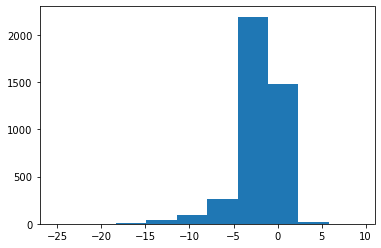

In [25]:
import matplotlib.pyplot as plt

plt.hist(df_result['Sales_PE'])

#df_result_test = run_clusters(which_model='test')



In [26]:
def only_enough_stat(df_tmp=df_result):
    df_true = df_tmp[df_tmp['has_enough_stat'] == True]
    return df_true


In [27]:
df_result_true = only_enough_stat(df_result)
#df_result_test_true = only_enough_stat(df_result_test)

(array([  2.,   0.,   0.,   2.,   1.,   3.,   4.,   6.,  13.,  14.,  23.,
         31.,  52.,  61., 121., 293., 635., 947.,  86.,   4.,   1.,   4.,
          1.,   0.,   1.]),
 array([-25.2784 , -23.91928, -22.56016, -21.20104, -19.84192, -18.4828 ,
        -17.12368, -15.76456, -14.40544, -13.04632, -11.6872 , -10.32808,
         -8.96896,  -7.60984,  -6.25072,  -4.8916 ,  -3.53248,  -2.17336,
         -0.81424,   0.54488,   1.904  ,   3.26312,   4.62224,   5.98136,
          7.34048,   8.6996 ]),
 <BarContainer object of 25 artists>)

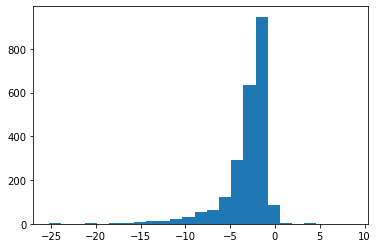

In [28]:
plt.hist(df_result_true['Sales_PE'], bins=25)

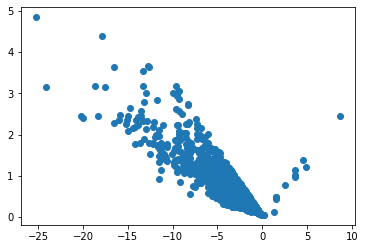

In [29]:
plt.scatter(df_result_true['Sales_PE'],df_result_true['Sales_PE_err'])

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 6.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 5.000e+00, 1.000e+01, 8.000e+00, 1.700e+01,
        4.700e+01, 2.590e+02, 1.882e+03, 4.300e+01, 7.000e+00, 6.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([-1.0344  , -0.964904, -0.895408, -0.825912, -0.756416, -0.68692 ,
        -0.617424, -0.547928, -0.478432, -0.408936, -0.33944 , -0.269944,
        -0.200448, -0.130952, -0.061456,  0.00804 ,  0.077536,  0.147032,
         0.216528,  0.286024,  0.35552 ,  0.425016,  0.494512,  0.564008,
         0.633504,  0.703   ]),
 <BarContainer object of 25 artists>)

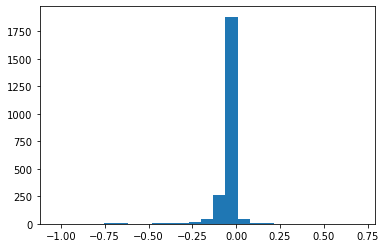

In [30]:
plt.hist(df_result_true['del_week'], bins=25)
#df_result_true['del_week'].min()


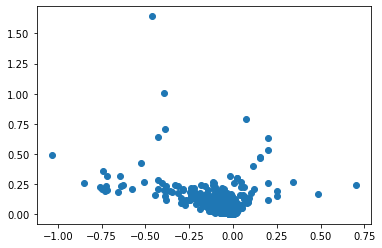

In [31]:
plt.scatter(df_result_true['del_week'],df_result_true['del_week_err'])

(array([  1.,   0.,   0.,   1.,   2.,   6.,   0., 118., 917., 627., 297.,
        129.,  72.,  44.,  25.,  28.,  11.,   9.,   6.,   6.,   3.,   0.,
          1.,   0.,   2.]),
 array([-51.6542  , -44.493124, -37.332048, -30.170972, -23.009896,
        -15.84882 ,  -8.687744,  -1.526668,   5.634408,  12.795484,
         19.95656 ,  27.117636,  34.278712,  41.439788,  48.600864,
         55.76194 ,  62.923016,  70.084092,  77.245168,  84.406244,
         91.56732 ,  98.728396, 105.889472, 113.050548, 120.211624,
        127.3727  ]),
 <BarContainer object of 25 artists>)

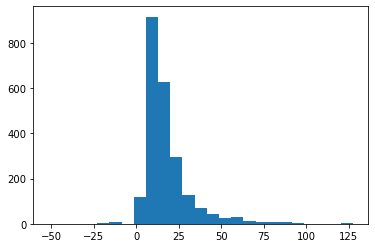

In [32]:
plt.hist(df_result_true['intercept'],bins=25)


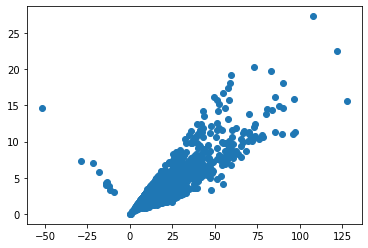

In [33]:
plt.scatter(df_result_true['intercept'], df_result_true['intercept_err'])

In [34]:
print(df_result_true['Sales_PE'].nlargest(10))
print(df_result_true['Sales_PE'].nsmallest(10))


000000001000118941    8.6996
000000001000083954    4.8458
000000001000205507    4.4961
000000001000007585    3.6450
000000001000063607    3.6253
000000001000021988    3.6143
000000001000126231    2.4969
000000001000009883    1.5883
000000001000011451    1.5874
000000001000151269    1.5302
Name: Sales_PE, dtype: float64
000000001000216192   -25.2784
000000001000016139   -24.1420
000000001000007432   -20.2014
000000001000016021   -20.0054
000000001000183810   -18.6393
000000001000007431   -18.2928
000000001000005341   -17.8777
000000001000022575   -17.5983
000000001000184087   -16.5873
000000001000007436   -16.5446
Name: Sales_PE, dtype: float64


In [35]:
def obtain_stats(df_tmp=df_result_true, which_model='test'):
    print('Model results: ', which_model)
    column = ''
    PE = ''
    if which_model == 'test':
        column = ['intercept', 'log_avg_sessions']
        PE = 'log_avg_sessions'
    elif which_model == 'std':
        column = ['intercept', 'Sales_PE', 'del_week']
        PE = ['Sales_PE']
    elif which_model == 'std_session':
        column = ['intercept', 'Sales_PE', 'del_week', 'log_avg_sessions']
        PE = ['Sales_PE']
    elif which_model == 'std_mkt_cost':
        column = ['intercept', 'Sales_PE', 'del_week', 'log_market_cost']
        PE = ['Sales_PE']
    print('Number of items = ', len(df_tmp.index))  #print number of items
    print('Max value = ', round(df_tmp[PE].max(), 3), ', Min value =', round(df_tmp[PE].min(), 3))  # print max & min
    #print(df_tmp[PE].nlargest(5),'\n',df_tmp[PE].nsmallest(5))
    import math
    for i in column:
        print(i)
        print('Mean\n', round(df_tmp[i].mean(), 3), '±', round(df_tmp[i].sem(), 3))
        print('Median\n ', round(df_tmp[i].median(), 3), '± ', round(1.253 * df_tmp[i].sem(), 3))
        print('\n')
    #print('Std ',round(df_tmp[column].std(),3))

In [36]:
obtain_stats(df_result_true, 'std')

Model results:  std
Number of items =  2305
Max value =  Sales_PE    8.7
dtype: float64 , Min value = Sales_PE   -25.278
dtype: float64
intercept
Mean
 17.624 ± 0.285
Median
  13.772 ±  0.358


Sales_PE
Mean
 -3.117 ± 0.055
Median
  -2.353 ±  0.069


del_week
Mean
 -0.039 ± 0.002
Median
  -0.023 ±  0.002




In [37]:
#for outliers in df_result_true[(df_result_true['Sales_PE'] > 0.)].index:
#    print(outliers)
#    df_result_true.drop(index=outliers, inplace=True)


In [38]:
#obtain_stats(df_result_true, 'std_mkt_cost')

In [39]:
df_result_true_final = df_result_true[
    ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err', 'intercept', 'intercept_err']]

In [40]:
df_result_true_final.head()


Sales_PE  Sales_PE_err  del_week  del_week_err  intercept  \
000000001000021922   -2.7164        0.2643   -0.0611        0.0123    13.5324   
000000001000080319   -2.0123        0.5307   -0.0389        0.0125    12.2816   
000000001000005727   -5.7830        0.9409   -0.0610        0.0520    29.7002   
000000001000007327   -2.9895        0.5150   -0.0096        0.0173    16.2228   
000000001000016194   -3.6670        0.4812   -0.0314        0.0125    19.4484   

                    intercept_err  
000000001000021922         1.2491  
000000001000080319         3.1825  
000000001000005727         4.3197  
000000001000007327         2.7397  
000000001000016194         2.4576

In [41]:
df_result_true_final.to_csv('./../raw_data/Excel_files/Top5k_Sales_PE_new_model_20210607_pre_campaign.csv')


In [88]:
df_result_session = run_clusters(which_model = 'std_session')

Number of items passing the PE cut 4148
Intercept                             12.698232
C(item_code)[T.000000001000008806]    -0.305766
C(item_code)[T.000000001000012524]    -0.204877
C(item_code)[T.000000001000012530]    -1.221379
C(item_code)[T.000000001000012678]    -0.796632
C(item_code)[T.000000001000012683]    -0.686576
C(item_code)[T.000000001000012685]    -0.639614
C(item_code)[T.000000001000032634]     0.404030
C(item_code)[T.000000001000039127]     0.503827
C(item_code)[T.000000001000050966]    -1.298508
C(item_code)[T.000000001000104126]    -0.923865
C(item_code)[T.000000001000116650]    -0.326325
C(item_code)[T.000000001000118131]    -0.893277
C(item_code)[T.000000001000128965]    -0.055737
C(item_code)[T.000000001000150712]     0.699332
log_avg_sessions                      -0.076220
log_price                             -2.044917
delivery_weeks                        -0.023315
dtype: float64
12.698231996755993   -2.0449170944117427   -0.023314633521845627
Intercept       

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             6.248427
C(item_code)[T.000000001000050886]    0.476494
C(item_code)[T.000000001000150713]    0.991512
C(item_code)[T.000000001000166550]    0.367888
C(item_code)[T.000000001000178078]    0.330893
C(item_code)[T.000000001000178079]    0.049130
C(item_code)[T.000000001000178080]    0.107759
C(item_code)[T.000000001000182823]    0.685322
C(item_code)[T.000000001000223473]   -0.047000
log_avg_sessions                     -0.196390
log_price                            -0.400419
delivery_weeks                       -0.003274
dtype: float64
6.248427073846648   -0.40041925304295767   -0.0032744006232837443
Intercept                             15.941428
C(item_code)[T.000000001000052448]    -0.611342
C(item_code)[T.000000001000052581]    -0.694499
C(item_code)[T.000000001000052646]    -0.168576
C(item_code)[T.000000001000063626]    -0.386657
C(item_code)[T.000000001000063628]    -0.296145
C(item_code)[T.000000001000064349]    -0.109816
C(item_code)[T.0000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             21.422778
C(item_code)[T.000000001000076754]     0.105132
C(item_code)[T.000000001000076755]     0.087682
C(item_code)[T.000000001000076760]     0.914340
C(item_code)[T.000000001000076780]     1.044935
C(item_code)[T.000000001000080045]     0.325696
C(item_code)[T.000000001000080376]     1.250439
C(item_code)[T.000000001000081875]     0.303712
C(item_code)[T.000000001000101668]    -0.159377
C(item_code)[T.000000001000121627]     0.550294
C(item_code)[T.000000001000121691]     0.331662
C(item_code)[T.000000001000133193]     0.779219
C(item_code)[T.000000001000133203]     0.719131
C(item_code)[T.000000001000136796]    -0.353037
C(item_code)[T.000000001000154789]    -0.093638
C(item_code)[T.000000001000214951]     0.061258
C(item_code)[T.000000001000214953]     0.035795
C(item_code)[T.000000001000221740]     0.943592
log_avg_sessions                      -0.677272
log_price                             -1.412439
delivery_weeks                        -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.222240
C(item_code)[T.000000001000015924]    -0.635713
C(item_code)[T.000000001000054177]    -1.758539
C(item_code)[T.000000001000054487]    -1.197395
C(item_code)[T.000000001000054489]    -0.977799
C(item_code)[T.000000001000064586]    -0.980148
C(item_code)[T.000000001000064588]    -1.002903
C(item_code)[T.000000001000064649]    -1.062202
C(item_code)[T.000000001000092536]    -1.434454
C(item_code)[T.000000001000123772]    -1.291448
C(item_code)[T.000000001000131842]    -1.320900
C(item_code)[T.000000001000182072]    -2.146297
C(item_code)[T.000000001000192755]    -1.516708
C(item_code)[T.000000001000202070]    -1.369229
C(item_code)[T.000000001000202077]    -1.474998
C(item_code)[T.000000001000202080]    -1.477276
C(item_code)[T.000000001000213257]    -1.898824
log_avg_sessions                      -0.197387
log_price                             -1.140636
delivery_weeks                        -0.023906
dtype: float64
11.222240185194032   -1.1

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept           25.272761
log_avg_sessions    -0.603865
log_price           -2.711631
delivery_weeks       0.011537
dtype: float64
25.27276143029789   -2.7116309071911857   0.01153690272703456
Intercept                             24.104601
C(item_code)[T.000000001000005759]    -0.309509
C(item_code)[T.000000001000005772]    -0.530788
C(item_code)[T.000000001000005775]     1.057609
C(item_code)[T.000000001000015613]     1.310159
C(item_code)[T.000000001000015629]     1.163735
C(item_code)[T.000000001000112672]     2.548961
C(item_code)[T.000000001000116741]    -0.268199
C(item_code)[T.000000001000123754]     2.072895
C(item_code)[T.000000001000138396]     2.796154
C(item_code)[T.000000001000161914]     0.991967
C(item_code)[T.000000001000167245]     2.708035
C(item_code)[T.000000001000171071]     1.128416
C(item_code)[T.000000001000179033]     1.514057
C(item_code)[T.000000001000218722]     3.059465
log_avg_sessions                      -0.728514
log_price                          

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             15.851338
C(item_code)[T.000000001000129535]    -1.389370
C(item_code)[T.000000001000137209]     7.466289
C(item_code)[T.000000001000176266]    -1.726193
C(item_code)[T.000000001000176291]     8.983698
C(item_code)[T.000000001000199233]    -3.692300
log_avg_sessions                       0.710249
log_price                             -5.583233
delivery_weeks                         0.068748
dtype: float64
15.851337702002102   -5.5832330932874   0.06874752989338773
Intercept                             5.017097
C(item_code)[T.000000001000127427]    0.012236
C(item_code)[T.000000001000187614]    0.490473
C(item_code)[T.000000001000187615]    0.314156
C(item_code)[T.000000001000193976]    0.256398
C(item_code)[T.000000001000200122]    0.290300
log_avg_sessions                     -0.205349
log_price                            -0.227626
delivery_weeks                       -0.023788
dtype: float64
5.0170971637116235   -0.22762559606586397   -0.02378780

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_res

Intercept                             19.161895
C(item_code)[T.000000001000007072]     1.089309
C(item_code)[T.000000001000008069]     0.257748
C(item_code)[T.000000001000008070]     0.474954
C(item_code)[T.000000001000039383]    -0.016740
C(item_code)[T.000000001000039495]     0.141533
C(item_code)[T.000000001000039550]    -0.832220
C(item_code)[T.000000001000048014]    -0.313122
C(item_code)[T.000000001000048015]    -0.058864
C(item_code)[T.000000001000059303]    -0.378456
C(item_code)[T.000000001000063626]    -0.072815
C(item_code)[T.000000001000064348]     0.294974
C(item_code)[T.000000001000087676]    -1.088228
C(item_code)[T.000000001000134815]    -0.100794
C(item_code)[T.000000001000134817]     0.732544
log_avg_sessions                      -0.392995
log_price                             -2.082120
delivery_weeks                        -0.042749
dtype: float64
19.161895170576546   -2.082120023602499   -0.04274860076355602
Intercept                             19.272856
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             41.843856
C(item_code)[T.000000001000123757]    -5.630290
C(item_code)[T.000000001000125113]     0.871993
C(item_code)[T.000000001000125117]    -3.147992
C(item_code)[T.000000001000138412]    -3.550369
C(item_code)[T.000000001000171107]     0.005031
C(item_code)[T.000000001000176221]    -2.988736
C(item_code)[T.000000001000176430]    -3.442485
C(item_code)[T.000000001000176747]     0.516728
C(item_code)[T.000000001000179468]    -5.602546
C(item_code)[T.000000001000184176]    -0.545951
C(item_code)[T.000000001000216151]    -0.712567
C(item_code)[T.000000001000216193]     0.537525
log_avg_sessions                      -0.157814
log_price                             -7.174489
delivery_weeks                        -0.028558
dtype: float64
41.84385634215125   -7.174488787007781   -0.02855823845737513
Intercept                             15.619179
C(item_code)[T.000000001000008815]     0.304445
C(item_code)[T.000000001000039131]    -0.347113
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             21.800912
C(item_code)[T.000000001000069226]     3.745091
C(item_code)[T.000000001000119744]     0.486655
C(item_code)[T.000000001000119757]     1.495220
C(item_code)[T.000000001000152766]    -0.175734
C(item_code)[T.000000001000171334]     1.132438
C(item_code)[T.000000001000177734]     0.422222
C(item_code)[T.000000001000177736]     1.029757
C(item_code)[T.000000001000177744]     0.210413
C(item_code)[T.000000001000186228]     0.614920
C(item_code)[T.000000001000223284]     0.723328
C(item_code)[T.000000001000223910]    -0.528604
log_avg_sessions                      -0.514594
log_price                             -2.052071
delivery_weeks                        -0.036725
dtype: float64
21.800911518449475   -2.052071420831156   -0.036725012448436255
Intercept                             13.177558
C(item_code)[T.000000001000008053]     0.045791
C(item_code)[T.000000001000015550]    -0.824130
C(item_code)[T.000000001000027404]     0.479625
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             25.970541
C(item_code)[T.000000001000007072]     1.333564
C(item_code)[T.000000001000008069]     0.154002
C(item_code)[T.000000001000008072]    -0.074367
C(item_code)[T.000000001000015743]    -0.958668
C(item_code)[T.000000001000033653]    -2.241537
C(item_code)[T.000000001000039495]    -0.316185
C(item_code)[T.000000001000048013]    -0.632838
C(item_code)[T.000000001000048014]    -0.815632
C(item_code)[T.000000001000059300]    -3.044408
C(item_code)[T.000000001000064348]     0.557524
C(item_code)[T.000000001000123220]    -0.125121
C(item_code)[T.000000001000134819]    -0.365325
C(item_code)[T.000000001000150777]    -3.142017
C(item_code)[T.000000001000202186]    -1.046658
log_avg_sessions                      -0.385663
log_price                             -3.324110
delivery_weeks                        -0.069856
dtype: float64
25.970540900666517   -3.3241102469283366   -0.0698557275053304
Intercept                             13.957577
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             25.508748
C(item_code)[T.000000001000008872]    -0.400327
C(item_code)[T.000000001000015708]    -0.096233
C(item_code)[T.000000001000047981]    -1.456958
C(item_code)[T.000000001000054500]    -3.475215
C(item_code)[T.000000001000057519]    -2.072043
C(item_code)[T.000000001000124600]    -0.975512
C(item_code)[T.000000001000124603]    -1.152448
C(item_code)[T.000000001000131647]    -3.464523
C(item_code)[T.000000001000131652]    -3.280217
C(item_code)[T.000000001000156830]    -2.654370
C(item_code)[T.000000001000168496]    -1.988359
C(item_code)[T.000000001000170728]    -1.801008
C(item_code)[T.000000001000172758]    -1.600882
C(item_code)[T.000000001000204350]    -1.256662
C(item_code)[T.000000001000205550]    -1.668503
C(item_code)[T.000000001000205566]    -2.009078
C(item_code)[T.000000001000211591]    -1.568941
C(item_code)[T.000000001000211718]    -1.544332
C(item_code)[T.000000001000214062]    -2.308193
log_avg_sessions                      -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



8.480689471017854   -1.2920131822707819   -0.09319262968024686
Intercept                             5.210691
C(item_code)[T.000000001000110071]   -1.642564
C(item_code)[T.000000001000110918]   -1.190387
C(item_code)[T.000000001000129416]    1.200863
C(item_code)[T.000000001000149292]   -0.252697
C(item_code)[T.000000001000150442]   -1.109541
C(item_code)[T.000000001000160306]   -0.618774
C(item_code)[T.000000001000178362]    0.553301
log_avg_sessions                      0.437797
log_price                            -2.571424
delivery_weeks                       -0.187248
dtype: float64
5.210691102617867   -2.57142405735508   -0.18724751759255653
Intercept          -11.553401
log_avg_sessions    -0.020340
log_price            2.314722
delivery_weeks      -0.051436
dtype: float64
-11.553400518421611   2.3147216926855627   -0.05143636157452627
Intercept                             19.158582
C(item_code)[T.000000001000072322]    -0.564930
C(item_code)[T.000000001000076800]    -2.056118


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             26.260381
C(item_code)[T.000000001000024955]    -3.755681
C(item_code)[T.000000001000037853]    -4.559841
C(item_code)[T.000000001000037861]    -4.635665
C(item_code)[T.000000001000037869]    -4.391877
C(item_code)[T.000000001000091266]    -2.321663
log_avg_sessions                      -0.987360
log_price                             -0.674697
delivery_weeks                        -0.035087
dtype: float64
26.26038114113488   -0.6746965277015731   -0.03508699300159099
Intercept                             21.702234
C(item_code)[T.000000001000047023]     3.019820
C(item_code)[T.000000001000047024]     1.253963
C(item_code)[T.000000001000056200]     6.375083
C(item_code)[T.000000001000123023]     1.697710
C(item_code)[T.000000001000128735]     1.224701
C(item_code)[T.000000001000128736]     2.719912
C(item_code)[T.000000001000149058]     5.284515
C(item_code)[T.000000001000167517]     1.306280
C(item_code)[T.000000001000167557]     3.443959
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.086310
C(item_code)[T.000000001000076413]    -0.113660
C(item_code)[T.000000001000076611]    -0.095058
C(item_code)[T.000000001000076756]     0.136897
C(item_code)[T.000000001000080300]    -0.016589
C(item_code)[T.000000001000080364]    -0.363913
C(item_code)[T.000000001000081920]    -0.134621
C(item_code)[T.000000001000081924]    -0.182879
C(item_code)[T.000000001000101016]    -0.048231
C(item_code)[T.000000001000101053]    -0.267317
C(item_code)[T.000000001000101087]     0.064253
C(item_code)[T.000000001000101103]     1.235797
C(item_code)[T.000000001000101110]     0.265762
C(item_code)[T.000000001000133159]    -0.204306
C(item_code)[T.000000001000133161]    -0.051279
C(item_code)[T.000000001000136121]     0.264758
C(item_code)[T.000000001000174532]     0.144336
log_avg_sessions                      -0.328634
log_price                             -0.794122
delivery_weeks                        -0.013890
dtype: float64
11.086310330152006   -0.7

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             11.381197
C(item_code)[T.000000001000047114]    -0.943799
C(item_code)[T.000000001000047118]    -1.069914
C(item_code)[T.000000001000104200]    -0.293804
C(item_code)[T.000000001000104324]    -1.011517
C(item_code)[T.000000001000118143]     0.624896
C(item_code)[T.000000001000123635]    -0.790572
C(item_code)[T.000000001000127099]    -0.745248
C(item_code)[T.000000001000147247]    -0.655260
C(item_code)[T.000000001000148112]    -1.273211
C(item_code)[T.000000001000178027]    -0.804886
C(item_code)[T.000000001000181275]    -1.207716
C(item_code)[T.000000001000187565]    -1.123495
C(item_code)[T.000000001000187580]    -1.495937
log_avg_sessions                      -0.243191
log_price                             -0.979284
delivery_weeks                        -0.025429
dtype: float64
11.38119709711172   -0.9792840021177504   -0.02542925537725574
Intercept                             25.736200
C(item_code)[T.000000001000027340]    -0.181342
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             20.672893
C(item_code)[T.000000001000052436]    -4.412959
C(item_code)[T.000000001000052437]    -3.177895
C(item_code)[T.000000001000052644]    -3.805410
C(item_code)[T.000000001000052645]    -2.880544
C(item_code)[T.000000001000098558]    -1.593896
C(item_code)[T.000000001000123634]    -1.375527
C(item_code)[T.000000001000123809]    -1.725806
C(item_code)[T.000000001000125633]    -1.038625
C(item_code)[T.000000001000125757]    -2.543041
C(item_code)[T.000000001000126876]    -1.735488
C(item_code)[T.000000001000127553]    -2.376818
C(item_code)[T.000000001000129138]    -3.781875
C(item_code)[T.000000001000145313]    -1.220815
C(item_code)[T.000000001000159195]    -3.051414
C(item_code)[T.000000001000184269]    -2.133229
C(item_code)[T.000000001000209069]    -3.455065
C(item_code)[T.000000001000209810]    -2.617790
log_avg_sessions                      -0.128063
log_price                             -2.532799
delivery_weeks                        -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept           7.206263
log_avg_sessions   -0.261956
log_price          -0.392478
delivery_weeks      0.004270
dtype: float64
7.206262561424667   -0.3924778083899416   0.004269654676844623
Intercept                             28.545378
C(item_code)[T.000000001000096428]     1.860048
C(item_code)[T.000000001000096476]     1.790541
C(item_code)[T.000000001000096497]     3.036014
C(item_code)[T.000000001000096508]     1.545121
C(item_code)[T.000000001000096511]     0.860926
C(item_code)[T.000000001000129053]     0.426809
C(item_code)[T.000000001000198945]    -1.590191
log_avg_sessions                      -0.556330
log_price                             -3.506825
delivery_weeks                        -0.115927
dtype: float64
28.54537828573645   -3.5068253937847955   -0.1159273455169107
Intercept                             47.984989
C(item_code)[T.000000001000008754]    -0.062689
C(item_code)[T.000000001000008841]    -7.026270
C(item_code)[T.000000001000008845]    -1.966475
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             43.507239
C(item_code)[T.000000001000133273]     2.598151
C(item_code)[T.000000001000134310]    -2.378311
C(item_code)[T.000000001000134872]    -0.256133
C(item_code)[T.000000001000142801]     0.915400
C(item_code)[T.000000001000153542]     3.741659
C(item_code)[T.000000001000182151]    -1.421119
C(item_code)[T.000000001000188378]    -0.840536
C(item_code)[T.000000001000188476]    -1.708857
C(item_code)[T.000000001000188542]     1.259361
C(item_code)[T.000000001000208185]    -1.160900
C(item_code)[T.000000001000225035]    -1.007001
C(item_code)[T.000000001000225037]    -1.076506
log_avg_sessions                      -1.129494
log_price                             -4.870180
delivery_weeks                        -0.509182
dtype: float64
43.50723909896874   -4.8701803960346925   -0.5091816289003426
Intercept                             42.145831
C(item_code)[T.000000001000007435]    -2.054120
C(item_code)[T.000000001000112669]     2.224030
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             15.734301
C(item_code)[T.000000001000020148]    -1.174971
C(item_code)[T.000000001000030932]    -1.753793
C(item_code)[T.000000001000094666]    -2.097560
C(item_code)[T.000000001000094670]    -1.247640
C(item_code)[T.000000001000119220]    -1.943365
C(item_code)[T.000000001000119233]    -1.792438
C(item_code)[T.000000001000119239]    -1.574816
C(item_code)[T.000000001000119248]    -1.850328
C(item_code)[T.000000001000119265]    -1.561739
log_avg_sessions                      -0.379381
log_price                             -1.022431
delivery_weeks                        -0.037561
dtype: float64
15.734301135444536   -1.0224311155142878   -0.037561064375705014
Intercept                             15.911178
C(item_code)[T.000000001000008013]    -0.540700
C(item_code)[T.000000001000097482]     0.201172
C(item_code)[T.000000001000113296]     0.711681
C(item_code)[T.000000001000119257]     0.283199
C(item_code)[T.000000001000119258]    -0.850308
C(item_c

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



14.12262346838125   -1.2915232903505582   -0.045409756492951675
Intercept                             14.347921
C(item_code)[T.000000001000053650]    -0.525203
C(item_code)[T.000000001000113241]    -0.491789
C(item_code)[T.000000001000127680]     0.220428
C(item_code)[T.000000001000131116]    -0.475350
log_avg_sessions                      -0.393548
log_price                             -0.883809
delivery_weeks                        -0.014802
dtype: float64
14.347920594371928   -0.883808689248013   -0.014802036408535571
Intercept                             2.947700
C(item_code)[T.000000001000052258]    0.208268
C(item_code)[T.000000001000052259]    0.068457
C(item_code)[T.000000001000056764]    0.106281
C(item_code)[T.000000001000063952]    0.170129
C(item_code)[T.000000001000064074]    0.154619
C(item_code)[T.000000001000064477]    0.338960
C(item_code)[T.000000001000084253]    0.233321
C(item_code)[T.000000001000119492]    0.493772
C(item_code)[T.000000001000119756]    0.303199
C(

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             16.294052
C(item_code)[T.000000001000012791]     0.248921
C(item_code)[T.000000001000012809]    -0.017657
C(item_code)[T.000000001000032623]     0.755509
C(item_code)[T.000000001000131876]    -0.637281
C(item_code)[T.000000001000137901]    -0.082159
C(item_code)[T.000000001000137913]    -1.225722
C(item_code)[T.000000001000145003]    -0.894594
C(item_code)[T.000000001000145006]    -0.837964
C(item_code)[T.000000001000145012]    -0.754322
C(item_code)[T.000000001000149755]    -0.295216
C(item_code)[T.000000001000167289]    -0.026433
C(item_code)[T.000000001000178745]    -0.611188
log_avg_sessions                      -0.473049
log_price                             -1.110451
delivery_weeks                        -0.020635
dtype: float64
16.29405153232585   -1.1104505365415671   -0.020635086068404584
Intercept                             5.018826
C(item_code)[T.000000001000027371]    0.471772
C(item_code)[T.000000001000027408]   -0.275340
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



10.76709055651124   -1.8599008877143017   10.767090556511228
Intercept                             25.276938
C(item_code)[T.000000001000098189]    -0.781951
C(item_code)[T.000000001000098190]     4.001639
C(item_code)[T.000000001000098206]    10.115932
C(item_code)[T.000000001000098239]     2.321677
C(item_code)[T.000000001000109927]     3.468080
C(item_code)[T.000000001000109988]    -0.077051
C(item_code)[T.000000001000110005]     1.351732
C(item_code)[T.000000001000137307]     0.802729
C(item_code)[T.000000001000149145]    -0.137352
C(item_code)[T.000000001000149149]     0.658410
C(item_code)[T.000000001000188280]     0.588557
log_avg_sessions                      -0.325379
log_price                             -4.540015
delivery_weeks                        -0.497254
dtype: float64
25.276937645137476   -4.540014785017229   -0.49725372285855307
Intercept                             22.425197
C(item_code)[T.000000001000021703]     0.803997
C(item_code)[T.000000001000054947]     1.564

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             19.312878
C(item_code)[T.000000001000030909]     0.181128
C(item_code)[T.000000001000086543]     1.215379
C(item_code)[T.000000001000103647]     0.926011
C(item_code)[T.000000001000103648]     0.889308
C(item_code)[T.000000001000126091]    -0.004436
C(item_code)[T.000000001000126203]     1.621305
C(item_code)[T.000000001000126915]     0.133110
C(item_code)[T.000000001000126927]     0.028514
C(item_code)[T.000000001000127939]     0.685791
C(item_code)[T.000000001000127956]     0.456239
C(item_code)[T.000000001000127964]     0.685153
C(item_code)[T.000000001000174658]     1.351553
log_avg_sessions                      -0.351762
log_price                             -2.218206
delivery_weeks                        -0.058259
dtype: float64
19.312878157372847   -2.2182064795913123   -0.05825917623117541
Intercept                             13.350978
C(item_code)[T.000000001000129382]     0.640175
C(item_code)[T.000000001000133271]    -0.368370
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             11.405960
C(item_code)[T.000000001000008032]     0.236467
C(item_code)[T.000000001000008526]    -0.034794
C(item_code)[T.000000001000056727]    -1.015954
C(item_code)[T.000000001000104259]    -0.338954
C(item_code)[T.000000001000104263]     0.120918
C(item_code)[T.000000001000104293]    -0.369939
C(item_code)[T.000000001000104316]     1.913812
C(item_code)[T.000000001000114940]    -1.390024
C(item_code)[T.000000001000116703]    -0.329446
C(item_code)[T.000000001000116705]    -0.474478
C(item_code)[T.000000001000149706]     0.029704
C(item_code)[T.000000001000163206]    -0.686444
C(item_code)[T.000000001000169032]    -0.604677
C(item_code)[T.000000001000211602]    -0.646589
log_avg_sessions                      -0.282536
log_price                             -0.983054
delivery_weeks                        -0.061675
dtype: float64
11.405960112507948   -0.9830539112904065   -0.06167510475301036
Intercept                             10.548530
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  re

Intercept                             10.189186
C(item_code)[T.000000001000032335]    -0.586974
C(item_code)[T.000000001000110912]    -1.211191
C(item_code)[T.000000001000110913]     0.218451
C(item_code)[T.000000001000110918]    -0.406461
C(item_code)[T.000000001000130641]    -0.728815
C(item_code)[T.000000001000130645]     0.644993
C(item_code)[T.000000001000130672]    -1.357409
C(item_code)[T.000000001000163073]     0.227834
C(item_code)[T.000000001000178362]     1.078998
C(item_code)[T.000000001000196884]    -0.409846
log_avg_sessions                      -0.001497
log_price                             -2.105896
delivery_weeks                         0.020366
dtype: float64
10.189185798820432   -2.10589615788762   0.02036585402800234
Intercept                             16.400556
C(item_code)[T.000000001000012641]    -1.575238
C(item_code)[T.000000001000039123]    -0.898798
C(item_code)[T.000000001000039722]    -1.319987
C(item_code)[T.000000001000109884]    -0.319950
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:762: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(SSR) * nobs2      # concen

Intercept                             27.183856
C(item_code)[T.000000001000008867]     2.611764
C(item_code)[T.000000001000008868]     2.843852
C(item_code)[T.000000001000008869]     2.487830
C(item_code)[T.000000001000008872]     1.349773
C(item_code)[T.000000001000039137]     0.981226
C(item_code)[T.000000001000040399]     0.266992
C(item_code)[T.000000001000050847]     0.984238
C(item_code)[T.000000001000050880]    -4.265804
C(item_code)[T.000000001000050881]    -1.651888
C(item_code)[T.000000001000123250]    -0.207139
C(item_code)[T.000000001000125845]     0.119375
C(item_code)[T.000000001000147153]     1.626030
C(item_code)[T.000000001000147156]     1.234524
C(item_code)[T.000000001000149752]     0.178457
C(item_code)[T.000000001000178069]     0.030398
C(item_code)[T.000000001000179342]    -4.243361
C(item_code)[T.000000001000204356]     0.022481
C(item_code)[T.000000001000211591]    -0.426786
log_avg_sessions                      -0.270009
log_price                             -3

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             13.824413
C(item_code)[T.000000001000008048]    -0.408712
C(item_code)[T.000000001000064222]     0.589929
C(item_code)[T.000000001000064530]     0.369916
C(item_code)[T.000000001000064531]     0.780708
C(item_code)[T.000000001000069118]     1.581413
C(item_code)[T.000000001000119754]     0.488593
C(item_code)[T.000000001000152587]     0.293260
C(item_code)[T.000000001000172407]    -0.421997
C(item_code)[T.000000001000173643]    -0.468582
C(item_code)[T.000000001000178634]    -0.317652
C(item_code)[T.000000001000182822]     1.108346
C(item_code)[T.000000001000191237]     0.503887
C(item_code)[T.000000001000225832]    -0.062866
log_avg_sessions                      -0.235027
log_price                             -1.562871
delivery_weeks                        -0.036862
dtype: float64
13.824412502766066   -1.562870611477359   -0.03686164984112289
Intercept                             5.878470
C(item_code)[T.000000001000052472]   -0.540668
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             11.983232
C(item_code)[T.000000001000007593]     0.133589
C(item_code)[T.000000001000007597]     1.082580
C(item_code)[T.000000001000015772]     0.830523
C(item_code)[T.000000001000015786]     0.430283
C(item_code)[T.000000001000051913]     2.013857
C(item_code)[T.000000001000086534]     0.890815
C(item_code)[T.000000001000126203]     1.855033
C(item_code)[T.000000001000127855]     0.233962
C(item_code)[T.000000001000127864]     0.659732
C(item_code)[T.000000001000127878]     0.453374
C(item_code)[T.000000001000127882]     0.221189
C(item_code)[T.000000001000129084]     1.417597
C(item_code)[T.000000001000145317]     0.406046
C(item_code)[T.000000001000174653]     0.582794
C(item_code)[T.000000001000174666]    -0.050551
C(item_code)[T.000000001000182528]     1.068034
C(item_code)[T.000000001000186229]     0.235026
C(item_code)[T.000000001000189271]     0.968979
C(item_code)[T.000000001000206997]     1.498973
log_avg_sessions                      -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             10.882732
C(item_code)[T.000000001000039125]     0.346084
C(item_code)[T.000000001000109884]     0.450014
C(item_code)[T.000000001000117169]    -0.291675
C(item_code)[T.000000001000119614]    -0.905713
C(item_code)[T.000000001000121274]     1.206305
C(item_code)[T.000000001000126041]     1.113463
C(item_code)[T.000000001000152214]    -0.478577
C(item_code)[T.000000001000163192]    -0.690504
C(item_code)[T.000000001000171219]    -0.129208
C(item_code)[T.000000001000176898]     0.152665
C(item_code)[T.000000001000191062]     0.699779
C(item_code)[T.000000001000201158]     0.863791
C(item_code)[T.000000001000210750]     0.731205
C(item_code)[T.000000001000211513]     0.309309
log_avg_sessions                      -0.123358
log_price                             -1.296268
delivery_weeks                        -0.029332
dtype: float64
10.88273173174775   -1.2962676470224683   -0.029332198362674058
Intercept                             18.610433
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             25.965644
C(item_code)[T.000000001000008058]     0.046282
C(item_code)[T.000000001000008072]    -1.252649
C(item_code)[T.000000001000015743]    -2.121083
C(item_code)[T.000000001000033653]    -3.480149
C(item_code)[T.000000001000039495]    -1.567159
C(item_code)[T.000000001000048014]    -2.022503
C(item_code)[T.000000001000048017]    -0.773017
C(item_code)[T.000000001000059300]    -4.334661
C(item_code)[T.000000001000123077]    -4.781502
C(item_code)[T.000000001000123131]    -4.377108
C(item_code)[T.000000001000125029]    -3.694307
C(item_code)[T.000000001000125030]    -5.107718
C(item_code)[T.000000001000134815]    -1.418837
C(item_code)[T.000000001000150777]    -4.260614
C(item_code)[T.000000001000167755]    -3.609927
log_avg_sessions                      -0.375929
log_price                             -3.132069
delivery_weeks                        -0.029930
dtype: float64
25.96564401156263   -3.1320690248089824   -0.029929969336206348
Intercept

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.159875
C(item_code)[T.000000001000016022]     4.433335
C(item_code)[T.000000001000016023]     2.192268
C(item_code)[T.000000001000016025]    -0.976230
C(item_code)[T.000000001000016139]     3.680928
C(item_code)[T.000000001000054046]     0.678378
C(item_code)[T.000000001000054423]    -0.162757
C(item_code)[T.000000001000054424]     0.849359
C(item_code)[T.000000001000128742]     0.742743
C(item_code)[T.000000001000128745]     0.785954
C(item_code)[T.000000001000128755]     1.253078
C(item_code)[T.000000001000176706]     0.512304
C(item_code)[T.000000001000179058]     2.279257
C(item_code)[T.000000001000191041]     0.251760
C(item_code)[T.000000001000208975]    -1.777597
C(item_code)[T.000000001000216190]    -0.406848
C(item_code)[T.000000001000216193]     0.659686
log_avg_sessions                      -0.820624
log_price                             -2.615424
delivery_weeks                        -0.016915
dtype: float64
29.159875152203714   -2.6

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.323383
C(item_code)[T.000000001000071165]    0.514834
C(item_code)[T.000000001000094955]   -0.133168
C(item_code)[T.000000001000113354]    0.227846
C(item_code)[T.000000001000175787]    0.109510
log_avg_sessions                     -0.149335
log_price                            -0.655758
delivery_weeks                       -0.005161
dtype: float64
7.323382699714593   -0.6557583136871954   -0.005161090406263937
Intercept                             10.472555
C(item_code)[T.000000001000192380]     1.557600
C(item_code)[T.000000001000193606]     1.094478
C(item_code)[T.000000001000208710]    -2.732143
C(item_code)[T.000000001000215132]     0.549949
log_avg_sessions                      -1.242807
log_price                              2.153296
delivery_weeks                        -0.090340
dtype: float64
10.47255473332058   2.1532958588046287   -0.09034025420021188
Intercept                             11.071295
C(item_code)[T.000000001000008863]  

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             26.321736
C(item_code)[T.000000001000097482]     2.145814
C(item_code)[T.000000001000113296]     2.089404
C(item_code)[T.000000001000119257]     1.219498
C(item_code)[T.000000001000119258]    -0.287412
log_avg_sessions                      -0.492436
log_price                             -2.878316
delivery_weeks                        -0.126155
dtype: float64
26.321736160058034   -2.878315977095384   -0.12615511257849596
Intercept                            -5.423862
C(item_code)[T.000000001000027051]   -3.932990
C(item_code)[T.000000001000166798]   -4.995908
C(item_code)[T.000000001000183448]   -3.726963
C(item_code)[T.000000001000189750]   -2.164918
log_avg_sessions                     -0.983626
log_price                             3.711183
delivery_weeks                       -0.018358
dtype: float64
-5.423862265127536   3.711183006465713   -0.018358122865693344
Intercept                             17.011581
C(item_code)[T.000000001000021833]  

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             46.117285
C(item_code)[T.000000001000007435]    -2.048985
C(item_code)[T.000000001000016096]    -1.136600
C(item_code)[T.000000001000016139]     2.218845
C(item_code)[T.000000001000117275]    -1.019467
C(item_code)[T.000000001000123817]    -1.995092
C(item_code)[T.000000001000123847]    -0.761183
C(item_code)[T.000000001000126061]    -1.931025
C(item_code)[T.000000001000138433]    -1.706317
C(item_code)[T.000000001000165503]     0.089621
C(item_code)[T.000000001000179467]    -2.389269
C(item_code)[T.000000001000183898]    -1.252679
C(item_code)[T.000000001000184193]    -3.139651
C(item_code)[T.000000001000216192]     1.707437
log_avg_sessions                      -1.340140
log_price                             -3.719159
delivery_weeks                        -0.173642
dtype: float64
46.11728494191181   -3.719159445795267   -0.17364239804232015
Intercept                             15.616706
C(item_code)[T.000000001000076607]     0.310744
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             34.630105
C(item_code)[T.000000001000015198]     1.424661
C(item_code)[T.000000001000034557]     1.099565
C(item_code)[T.000000001000053584]    -0.505018
C(item_code)[T.000000001000053671]     0.198408
C(item_code)[T.000000001000073168]     1.265321
C(item_code)[T.000000001000073182]     0.466432
C(item_code)[T.000000001000128818]     0.400885
C(item_code)[T.000000001000130676]     0.344717
C(item_code)[T.000000001000172942]     0.767733
C(item_code)[T.000000001000172943]     0.231419
log_avg_sessions                      -0.563300
log_price                             -3.802221
delivery_weeks                        -0.020840
dtype: float64
34.630105451847136   -3.802221397743223   -0.020840115552712625
Intercept                             18.541237
C(item_code)[T.000000001000076731]     0.210741
C(item_code)[T.000000001000076754]    -0.051477
C(item_code)[T.000000001000076760]     0.735331
C(item_code)[T.000000001000076844]    -0.256573
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             2.303770
C(item_code)[T.000000001000021877]    0.023790
C(item_code)[T.000000001000076521]    0.159050
C(item_code)[T.000000001000076851]    0.225642
C(item_code)[T.000000001000076853]    0.146344
C(item_code)[T.000000001000079568]    0.053670
C(item_code)[T.000000001000079572]    0.039529
C(item_code)[T.000000001000101043]    0.071462
C(item_code)[T.000000001000101235]    0.174864
C(item_code)[T.000000001000101236]    0.152397
C(item_code)[T.000000001000121609]    0.231018
C(item_code)[T.000000001000123326]    0.155305
C(item_code)[T.000000001000131585]    0.318487
C(item_code)[T.000000001000175587]    0.013758
C(item_code)[T.000000001000175589]    0.248268
C(item_code)[T.000000001000175611]    0.277528
C(item_code)[T.000000001000175614]    0.269817
C(item_code)[T.000000001000180154]    0.023103
C(item_code)[T.000000001000216098]    0.291925
log_avg_sessions                     -0.031058
log_price                            -0.276204
delivery_week

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.105182
C(item_code)[T.000000001000073158]     0.395659
C(item_code)[T.000000001000073159]     0.480238
C(item_code)[T.000000001000073164]    -0.762329
C(item_code)[T.000000001000085324]    -1.447118
C(item_code)[T.000000001000094684]    -0.798351
C(item_code)[T.000000001000125780]     0.636432
C(item_code)[T.000000001000128818]    -0.262050
C(item_code)[T.000000001000172911]     0.676470
C(item_code)[T.000000001000172950]    -0.418806
log_avg_sessions                      -0.618681
log_price                             -2.648505
delivery_weeks                        -0.025466
dtype: float64
29.105181525740733   -2.648505230312881   -0.025465501056835482
Intercept                             32.927682
C(item_code)[T.000000001000008063]    -3.067806
C(item_code)[T.000000001000008077]     0.103123
C(item_code)[T.000000001000008078]     1.572609
C(item_code)[T.000000001000008080]     0.355705
C(item_code)[T.000000001000015743]    -3.117705
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.361543
C(item_code)[T.000000001000054418]    -6.646033
C(item_code)[T.000000001000059370]    -6.767968
C(item_code)[T.000000001000059372]    -2.879774
C(item_code)[T.000000001000116755]    -8.339224
C(item_code)[T.000000001000117683]    -3.929291
C(item_code)[T.000000001000123742]    -6.568455
C(item_code)[T.000000001000128743]    -6.851579
C(item_code)[T.000000001000128764]    -6.285423
C(item_code)[T.000000001000128953]    -6.652053
C(item_code)[T.000000001000170681]    -6.435493
C(item_code)[T.000000001000170692]    -6.737662
C(item_code)[T.000000001000202053]    -7.783095
C(item_code)[T.000000001000226000]    -6.388416
log_avg_sessions                      -0.132006
log_price                             -3.878963
delivery_weeks                        -0.038438
dtype: float64
29.36154275472901   -3.8789629657498974   -0.03843750000451915
Intercept                             17.042885
C(item_code)[T.000000001000079675]    -2.261240
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.024723
C(item_code)[T.000000001000008809]    1.466645
C(item_code)[T.000000001000008814]    0.578997
C(item_code)[T.000000001000039135]    0.326341
C(item_code)[T.000000001000050867]    0.687527
C(item_code)[T.000000001000050952]    0.496730
C(item_code)[T.000000001000117190]    0.389968
C(item_code)[T.000000001000126038]    0.243454
C(item_code)[T.000000001000126039]    0.175666
C(item_code)[T.000000001000166778]    0.236108
C(item_code)[T.000000001000166781]    0.222473
C(item_code)[T.000000001000176687]    0.111778
C(item_code)[T.000000001000180840]   -0.015392
C(item_code)[T.000000001000182822]    0.803825
C(item_code)[T.000000001000182841]    0.207049
C(item_code)[T.000000001000207058]    0.627796
log_avg_sessions                     -0.093031
log_price                            -0.836557
delivery_weeks                       -0.031194
dtype: float64
7.024722855578635   -0.8365568927430439   -0.031193807597673553
Intercept                   

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             32.497416
C(item_code)[T.000000001000016101]     5.757187
C(item_code)[T.000000001000054049]     2.572347
C(item_code)[T.000000001000054418]     1.065735
C(item_code)[T.000000001000059372]     4.817066
C(item_code)[T.000000001000112678]     0.656526
C(item_code)[T.000000001000117258]     3.007774
C(item_code)[T.000000001000117683]     3.877471
C(item_code)[T.000000001000123742]     1.074071
C(item_code)[T.000000001000128743]     0.799079
C(item_code)[T.000000001000128764]     1.415000
C(item_code)[T.000000001000167714]     3.781048
C(item_code)[T.000000001000170692]     0.970581
C(item_code)[T.000000001000184095]    -0.518141
C(item_code)[T.000000001000202053]    -0.211180
log_avg_sessions                      -0.678845
log_price                             -3.997989
delivery_weeks                        -0.052744
dtype: float64
32.497416490052515   -3.997988737416429   -0.0527441754501193
Intercept                             13.149504
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             12.720251
C(item_code)[T.000000001000109909]     2.972469
C(item_code)[T.000000001000109911]     1.509420
C(item_code)[T.000000001000114079]     1.829753
C(item_code)[T.000000001000117186]     3.029217
C(item_code)[T.000000001000123447]     2.560934
C(item_code)[T.000000001000123449]     2.158647
C(item_code)[T.000000001000123522]     2.646990
C(item_code)[T.000000001000129702]     0.508511
C(item_code)[T.000000001000150467]     0.622189
C(item_code)[T.000000001000152836]     1.515384
C(item_code)[T.000000001000178608]     2.993566
C(item_code)[T.000000001000194258]     1.390139
C(item_code)[T.000000001000209635]     1.847812
C(item_code)[T.000000001000214949]     2.426720
log_avg_sessions                      -0.157830
log_price                             -2.251930
delivery_weeks                        -0.049851
dtype: float64
12.720250851920312   -2.2519300793625154   -0.04985087371055294
Intercept                             15.891676
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             17.290897
C(item_code)[T.000000001000117699]     1.094027
C(item_code)[T.000000001000137304]    -0.368548
C(item_code)[T.000000001000153506]    -0.264670
C(item_code)[T.000000001000153558]    -0.328260
C(item_code)[T.000000001000156992]     0.519969
C(item_code)[T.000000001000156999]     0.936798
C(item_code)[T.000000001000157000]    -1.459614
C(item_code)[T.000000001000157002]     0.744755
C(item_code)[T.000000001000157274]    -0.404872
C(item_code)[T.000000001000160416]    -0.599687
C(item_code)[T.000000001000179649]    -1.486305
C(item_code)[T.000000001000179650]     0.472865
C(item_code)[T.000000001000179652]     0.886198
C(item_code)[T.000000001000182946]     0.919885
C(item_code)[T.000000001000187382]    -0.025219
C(item_code)[T.000000001000187400]    -0.192657
C(item_code)[T.000000001000188310]     0.335966
C(item_code)[T.000000001000188390]     0.992155
C(item_code)[T.000000001000200431]    -0.532056
log_avg_sessions                      -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             30.996773
C(item_code)[T.000000001000063602]    -0.792967
C(item_code)[T.000000001000064394]    -0.256320
C(item_code)[T.000000001000168550]    -2.000541
C(item_code)[T.000000001000168572]    -2.531001
C(item_code)[T.000000001000168580]    -0.211412
C(item_code)[T.000000001000175274]    -0.813853
C(item_code)[T.000000001000175282]    -0.686588
C(item_code)[T.000000001000175284]    -1.028491
C(item_code)[T.000000001000198943]    -1.134062
C(item_code)[T.000000001000198945]    -3.985712
C(item_code)[T.000000001000210724]    -1.201676
C(item_code)[T.000000001000211328]    -1.195965
C(item_code)[T.000000001000211342]    -0.727386
log_avg_sessions                      -0.671430
log_price                             -3.007955
delivery_weeks                        -0.138427
dtype: float64
30.996773449814803   -3.007955222137009   -0.138426777775534
Intercept                             11.131827
C(item_code)[T.000000001000020148]     0.195773
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             30.290021
C(item_code)[T.000000001000008550]    -1.007657
C(item_code)[T.000000001000065870]    -1.674469
C(item_code)[T.000000001000210465]     0.331777
log_avg_sessions                      -0.081910
log_price                             -4.044747
delivery_weeks                        -0.120506
dtype: float64
30.29002078729387   -4.044746876958071   -0.12050588856979641
Intercept                             25.879711
C(item_code)[T.000000001000054376]    -0.111360
C(item_code)[T.000000001000054377]    -0.003226
C(item_code)[T.000000001000069675]     4.123936
C(item_code)[T.000000001000110046]    -1.243275
C(item_code)[T.000000001000110081]    -0.040619
C(item_code)[T.000000001000118448]    -0.665590
C(item_code)[T.000000001000120926]    -1.392942
C(item_code)[T.000000001000123550]     1.036383
C(item_code)[T.000000001000124781]    -1.411910
C(item_code)[T.000000001000153511]    -0.478311
C(item_code)[T.000000001000168742]    -0.867852
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             1.690824
C(item_code)[T.000000001000030870]   -0.156929
C(item_code)[T.000000001000030876]    0.021559
C(item_code)[T.000000001000030982]    0.079273
C(item_code)[T.000000001000031385]   -0.032200
C(item_code)[T.000000001000031389]    0.018019
C(item_code)[T.000000001000040784]   -0.164568
C(item_code)[T.000000001000054762]    0.111992
C(item_code)[T.000000001000073205]    0.228315
C(item_code)[T.000000001000073206]    0.169162
C(item_code)[T.000000001000094677]   -0.190255
C(item_code)[T.000000001000118252]   -0.111167
C(item_code)[T.000000001000145878]   -0.025116
log_avg_sessions                     -0.076141
log_price                            -0.014484
delivery_weeks                        0.000134
dtype: float64
1.6908237398648667   -0.014484441178553409   0.00013382031375398155
Intercept                             43.590457
C(item_code)[T.000000001000007434]     0.648117
C(item_code)[T.000000001000007435]     1.137705
C(item_code)[T.000000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.781701
C(item_code)[T.000000001000052286]    -2.110028
C(item_code)[T.000000001000052438]    -2.234198
C(item_code)[T.000000001000064337]    -1.056656
C(item_code)[T.000000001000104033]    -1.174295
C(item_code)[T.000000001000119387]    -1.957693
C(item_code)[T.000000001000126213]    -1.256483
C(item_code)[T.000000001000135857]    -1.752414
C(item_code)[T.000000001000145854]    -0.936674
C(item_code)[T.000000001000158712]    -1.747658
C(item_code)[T.000000001000209820]    -1.932395
C(item_code)[T.000000001000210952]    -1.439795
C(item_code)[T.000000001000222749]    -1.875534
log_avg_sessions                      -0.333606
log_price                             -0.663194
delivery_weeks                         0.002942
dtype: float64
11.781701378256018   -0.6631936728173666   0.00294151653255232
Intercept                             11.319852
C(item_code)[T.000000001000076611]     0.122162
C(item_code)[T.000000001000101016]     0.069115
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             5.411324
C(item_code)[T.000000001000027371]    0.475270
C(item_code)[T.000000001000027408]   -0.308566
C(item_code)[T.000000001000064685]   -0.113787
C(item_code)[T.000000001000092074]   -0.828468
C(item_code)[T.000000001000104254]   -0.239595
C(item_code)[T.000000001000104429]   -0.697006
C(item_code)[T.000000001000104446]   -0.388268
C(item_code)[T.000000001000104518]   -0.119017
C(item_code)[T.000000001000123644]   -0.481563
C(item_code)[T.000000001000123648]   -0.338232
C(item_code)[T.000000001000147263]   -0.686769
C(item_code)[T.000000001000196336]   -0.440466
log_avg_sessions                     -0.067878
log_price                            -0.554428
delivery_weeks                       -0.005138
dtype: float64
5.411323710086279   -0.5544276186697087   -0.005138111260360943
Intercept                             31.313020
C(item_code)[T.000000001000008016]     0.679850
C(item_code)[T.000000001000039526]    -2.766461
C(item_code)[T.0000000010

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             22.160539
C(item_code)[T.000000001000087137]    -1.396217
C(item_code)[T.000000001000087307]    -0.440937
C(item_code)[T.000000001000150676]    -0.333228
C(item_code)[T.000000001000152007]    -0.512786
C(item_code)[T.000000001000178404]    -0.894950
C(item_code)[T.000000001000188242]    -0.834578
C(item_code)[T.000000001000192637]    -0.824294
C(item_code)[T.000000001000194077]     0.391814
C(item_code)[T.000000001000206731]    -0.403806
C(item_code)[T.000000001000207390]    -0.409627
C(item_code)[T.000000001000208500]    -0.260114
C(item_code)[T.000000001000208899]    -0.494347
C(item_code)[T.000000001000209275]    -0.517853
log_avg_sessions                      -0.835550
log_price                             -1.066570
delivery_weeks                        -0.079296
dtype: float64
22.160539236827994   -1.0665695487096147   -0.07929601749505677
Intercept                             26.517809
C(item_code)[T.000000001000087606]    -1.735370
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



19.25497820231966   -6.618454790069368   -0.11840301114539507
Intercept                             3.353414
C(item_code)[T.000000001000021845]    0.306971
C(item_code)[T.000000001000143693]   -0.015907
C(item_code)[T.000000001000143697]   -0.121515
C(item_code)[T.000000001000151282]    0.081174
C(item_code)[T.000000001000199690]   -0.021392
C(item_code)[T.000000001000199694]   -0.084543
C(item_code)[T.000000001000199709]    0.067569
C(item_code)[T.000000001000200182]   -0.209213
C(item_code)[T.000000001000200898]    0.106298
C(item_code)[T.000000001000200906]    0.187195
C(item_code)[T.000000001000212971]   -0.033434
C(item_code)[T.000000001000218484]    0.070175
log_avg_sessions                      0.060025
log_price                            -0.608240
delivery_weeks                       -0.006346
dtype: float64
3.353414347463792   -0.6082404455558271   -0.006346278031044212
Intercept                             23.062627
C(item_code)[T.000000001000055018]     2.027128
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nob

Intercept                             9.184759
C(item_code)[T.000000001000120669]    0.126498
C(item_code)[T.000000001000125848]    0.422091
C(item_code)[T.000000001000126242]    0.033480
C(item_code)[T.000000001000148043]    0.218492
C(item_code)[T.000000001000150676]    0.133166
C(item_code)[T.000000001000166801]    0.486244
C(item_code)[T.000000001000178209]   -0.160968
C(item_code)[T.000000001000180487]    0.110676
C(item_code)[T.000000001000188242]   -0.180089
C(item_code)[T.000000001000192637]   -0.036726
C(item_code)[T.000000001000195868]    0.198889
C(item_code)[T.000000001000206731]    0.435881
C(item_code)[T.000000001000207390]    0.386904
C(item_code)[T.000000001000208507]    0.291451
C(item_code)[T.000000001000215538]    0.068568
C(item_code)[T.000000001000219367]   -0.573309
log_avg_sessions                     -0.330774
log_price                            -0.537415
delivery_weeks                       -0.019073
dtype: float64
9.184758896506317   -0.53741456994098   -0.01

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             14.683943
C(item_code)[T.000000001000047702]    -0.704098
C(item_code)[T.000000001000087136]    -1.428782
C(item_code)[T.000000001000087137]    -1.446400
C(item_code)[T.000000001000087518]    -0.661842
C(item_code)[T.000000001000172195]    -0.884465
C(item_code)[T.000000001000178206]    -1.585909
C(item_code)[T.000000001000188237]    -1.817801
C(item_code)[T.000000001000194077]     0.260911
C(item_code)[T.000000001000205522]    -0.655515
C(item_code)[T.000000001000205933]    -0.550294
C(item_code)[T.000000001000206720]    -1.266068
C(item_code)[T.000000001000208890]    -0.542450
C(item_code)[T.000000001000221681]    -0.530155
log_avg_sessions                      -0.395504
log_price                             -1.230339
delivery_weeks                        -0.038308
dtype: float64
14.683942644589802   -1.230338713784719   -0.0383082106077546
Intercept                             12.835681
C(item_code)[T.000000001000027431]    -0.253477
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             34.612587
C(item_code)[T.000000001000058326]     0.814703
C(item_code)[T.000000001000151776]    -2.038365
C(item_code)[T.000000001000195501]    -0.725008
C(item_code)[T.000000001000199400]     1.444081
C(item_code)[T.000000001000202197]    -2.184496
C(item_code)[T.000000001000208523]    -0.530242
C(item_code)[T.000000001000208524]    -0.618347
C(item_code)[T.000000001000208525]    -1.118074
C(item_code)[T.000000001000208526]     0.265605
log_avg_sessions                      -0.707138
log_price                             -3.168895
delivery_weeks                        -0.044572
dtype: float64
34.612586946607706   -3.168895070935697   -0.044571766701380314
Intercept                             41.776439
C(item_code)[T.000000001000058325]     2.527397
C(item_code)[T.000000001000058326]     3.700797
C(item_code)[T.000000001000151789]    -2.103695
C(item_code)[T.000000001000164771]     1.637510
C(item_code)[T.000000001000195406]     1.540316
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [93]:
df_result_session= df_result_session[df_result_session['Sales_PE'] < 10.]

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 1.400e+01, 1.900e+01,
        1.900e+01, 3.900e+01, 6.100e+01, 1.270e+02, 2.780e+02, 8.200e+02,
        1.925e+03, 7.920e+02, 2.300e+01, 7.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00]),
 array([-33.0577  , -31.353828, -29.649956, -27.946084, -26.242212,
        -24.53834 , -22.834468, -21.130596, -19.426724, -17.722852,
        -16.01898 , -14.315108, -12.611236, -10.907364,  -9.203492,
         -7.49962 ,  -5.795748,  -4.091876,  -2.388004,  -0.684132,
          1.01974 ,   2.723612,   4.427484,   6.131356,   7.835228,
          9.5391  ]),
 <BarContainer object of 25 artists>)

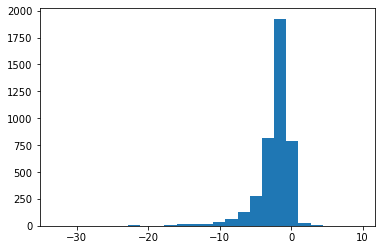

In [94]:
plt.hist(df_result_session['Sales_PE'], bins=25)


In [95]:
df_result_session_true = only_enough_stat(df_result_session)


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   2.,   1.,
          1.,   6.,   8.,  11.,  21.,  16.,  27.,  36.,  59., 104., 198.,
        494., 887., 505.]),
 array([-33.0577  , -31.743096, -30.428492, -29.113888, -27.799284,
        -26.48468 , -25.170076, -23.855472, -22.540868, -21.226264,
        -19.91166 , -18.597056, -17.282452, -15.967848, -14.653244,
        -13.33864 , -12.024036, -10.709432,  -9.394828,  -8.080224,
         -6.76562 ,  -5.451016,  -4.136412,  -2.821808,  -1.507204,
         -0.1926  ]),
 <BarContainer object of 25 artists>)

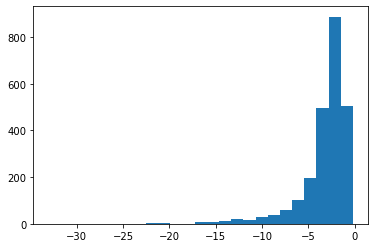

In [96]:
plt.hist(df_result_session_true['Sales_PE'], bins=25)

(array([1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 3.00e+00, 4.00e+00, 4.00e+00, 5.00e+00,
        7.00e+00, 1.20e+01, 7.00e+00, 1.50e+01, 1.30e+01, 3.00e+01,
        7.10e+01, 1.64e+02, 4.04e+02, 1.10e+03, 4.95e+02, 3.70e+01,
        8.00e+00]),
 array([-6.9329  , -6.624444, -6.315988, -6.007532, -5.699076, -5.39062 ,
        -5.082164, -4.773708, -4.465252, -4.156796, -3.84834 , -3.539884,
        -3.231428, -2.922972, -2.614516, -2.30606 , -1.997604, -1.689148,
        -1.380692, -1.072236, -0.76378 , -0.455324, -0.146868,  0.161588,
         0.470044,  0.7785  ]),
 <BarContainer object of 25 artists>)

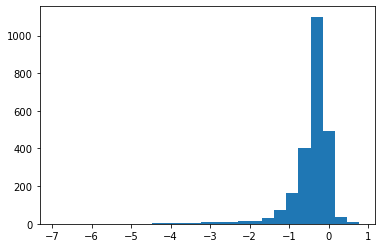

In [97]:
plt.hist(df_result_session_true['log_avg_sessions'], bins=25)


(array([1.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 6.000e+00,
        7.000e+00, 2.500e+01, 7.500e+01, 2.960e+02, 1.763e+03, 1.570e+02,
        1.500e+01, 6.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([-0.8441  , -0.767592, -0.691084, -0.614576, -0.538068, -0.46156 ,
        -0.385052, -0.308544, -0.232036, -0.155528, -0.07902 , -0.002512,
         0.073996,  0.150504,  0.227012,  0.30352 ,  0.380028,  0.456536,
         0.533044,  0.609552,  0.68606 ,  0.762568,  0.839076,  0.915584,
         0.992092,  1.0686  ]),
 <BarContainer object of 25 artists>)

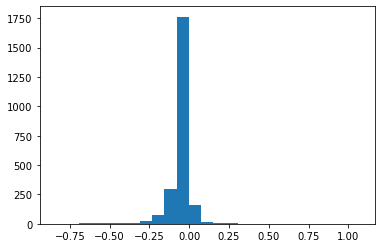

In [100]:
plt.hist(df_result_session_true['del_week'], bins=25)

In [103]:
obtain_stats(df_result_session_true,'std_session')

Model results:  std_session
Number of items =  2380
Max value =  Sales_PE   -0.193
dtype: float64 , Min value = Sales_PE   -33.058
dtype: float64
intercept
Mean
 26.329 ± 0.459
Median
  20.173 ±  0.575


Sales_PE
Mean
 -3.227 ± 0.056
Median
  -2.427 ±  0.07


del_week
Mean
 -0.048 ± 0.002
Median
  -0.033 ±  0.002


log_avg_sessions
Mean
 -0.439 ± 0.011
Median
  -0.31 ±  0.014




In [46]:
###INTRODUCING THE REST
print(df_result_true_final.head(1000))
print(df_result_true_final.dtypes)

                    Sales_PE  Sales_PE_err  del_week  del_week_err  intercept  \
000000001000012530   -1.8574        0.5205    0.0525        0.0541     9.9566   
000000001000021922   -2.5328        0.2974   -0.0481        0.0138    12.6504   
000000001000080319   -1.4312        0.3388   -0.0228        0.0077     8.7457   
000000001000125896   -0.5691        0.1797   -0.0063        0.0046     3.8694   
000000001000005727   -5.8260        1.0061   -0.0560        0.0558    29.7552   
...                      ...           ...       ...           ...        ...   
000000001000027357   -4.0178        1.2134   -0.0423        0.0147    21.8062   
000000001000027437  -13.9285        2.5499    0.0021        0.0221    71.5191   
000000001000116888   -6.7955        1.2256   -0.0170        0.0113    42.5781   
000000001000171117   -1.4772        0.4382   -0.0264        0.0221     9.7684   
000000001000174644   -1.5850        0.3185   -0.0132        0.0078     9.0814   

                    interce

In [47]:
#PREPARE THE CONVERSION RATE FILE
#final_items = list(df_result_true.index.values)
final_items = list(df_result_true_final.index.values)
print(len(final_items))



2389


In [48]:
print(df_filt.head(10))

      min_date    max_date           item_code  item_price_x  delivery_weeks  \
0   2020-01-01  2020-05-23  000000001000012530         99.99               1   
2   2020-05-31  2020-06-26  000000001000012530         99.99               1   
5   2020-08-06  2020-08-20  000000001000012530         99.99               1   
7   2020-09-16  2020-10-31  000000001000012530         99.99               1   
8   2020-11-01  2020-11-07  000000001000012530         99.99               1   
9   2020-11-10  2020-11-22  000000001000012530         99.99               1   
11  2020-12-08  2020-12-27  000000001000012530         99.99               1   
12  2021-01-05  2021-02-13  000000001000012530         99.99               1   
13  2020-01-01  2020-03-13  000000001000021922        129.99               2   
14  2020-04-15  2020-04-21  000000001000021922        119.99               4   

    avg_sales  avg_unique_views  avg_sessions  avg_marketing_cost_spend  \
0    0.520833         35.743056  1.571017e+0

In [49]:
#df_final = df_filt[['item_code','max_date','item_price_x','conv_rate','avg_sales', 'avg_unique_views']]

#print(df_final.head())

In [50]:
df_final= df_filt[df_filt['item_code'].isin(final_items)]

In [51]:
print(df_final.head())

     min_date    max_date           item_code  item_price_x  delivery_weeks  \
0  2020-01-01  2020-05-23  000000001000012530         99.99               1   
2  2020-05-31  2020-06-26  000000001000012530         99.99               1   
5  2020-08-06  2020-08-20  000000001000012530         99.99               1   
7  2020-09-16  2020-10-31  000000001000012530         99.99               1   
8  2020-11-01  2020-11-07  000000001000012530         99.99               1   

   avg_sales  avg_unique_views  avg_sessions  avg_marketing_cost_spend  \
0   0.520833         35.743056  1.571017e+08             180433.654445   
2   0.444444         49.814815  1.285261e+08              92373.876624   
5   0.533333         19.800000  1.066574e+08             123726.228592   
7   0.478261         36.652174  1.345811e+08             233867.366074   
8   1.714286         81.142857  1.501779e+08             305831.619103   

   conv_rate  ...  item_sub_category_1 item_sub_category_2 log_price  \
0   0.01

In [52]:
df_to_spark = df_final.groupby(['item_code']).nth(-1)
df_to_spark.reset_index(level=0,inplace=True)
df_to_spark.rename(columns={'index':'item_code'}, inplace=True)
spark_check = spark.createDataFrame(df_to_spark)


In [53]:
spark_check.show()

+------------------+----------+----------+------------+--------------+--------------------+------------------+--------------------+------------------------+--------------------+---+---------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+-------------------+------------------+----------------------------+------------+
|         item_code|  min_date|  max_date|item_price_x|delivery_weeks|           avg_sales|  avg_unique_views|        avg_sessions|avg_marketing_cost_spend|           conv_rate|bin|item_parent_item_code|  item_main_category| item_sub_category_1|item_sub_category_2|         log_price|  log_delivery_weeks|           log_sales|log_avg_unique_views|      log_conv_rate|  log_avg_sessions|log_avg_marketing_cost_spend|item_price_y|
+------------------+----------+----------+------------+--------------+--------------------+------------------+--------------------+-----------

In [54]:
spark_df = spark.createDataFrame(df_final)

In [55]:
spark_df.createOrReplaceTempView('Final_table')


In [ ]:
spark_last_price = spark.sql("""with max_price as (
                                SELECT item_code,
                                ROW_NUMBER() over (PARTITION BY item_code ORDER BY max_date DESC) as rn,
                                item_price_x,
                                max_date
                                from Final_table)
                            SELECT item_code, item_price_x, max_date
                            from max_price
                            where rn=1
                            """)
spark_last_price.show()

In [ ]:
spark_last_price.createOrReplaceTempView('last_price')


In [ ]:
spark_check.createOrReplaceTempView('check_last_price')


In [ ]:
disjoint_spark = spark.sql("""SELECT *
                                from check_last_price as clp
                                inner join last_price as lp on lp.item_code = clp.item_code and lp.item_price_x!= clp.item_price_x  """)

disjoint_spark.show()

In [ ]:
spark_filter = spark.sql("""SELECT ft.item_code, AVG(ft.conv_rate) as avg_conv_rate, MAX(ft.item_price_x) as last_price, MAX(ft.max_date) as last_date, AVG(avg_unique_views) as avg_unique_views
                            from Final_table as ft
                            inner join last_price as lp on lp.item_code = ft.item_code and lp.item_price_x = ft.item_price_x
                            GROUP BY ft.item_code
                            """)
spark_filter.show()

In [ ]:
spark_filter.createOrReplaceTempView('Final_table_filt')



In [ ]:

#df_result_true.reset_index(level=0,inplace=True)
df_result_true_final.reset_index(level=0,inplace=True)



In [ ]:
df_result_true_final.rename(columns={'index':'item_code'}, inplace=True)

In [ ]:
print(df_result_true_final.head())

In [ ]:
spark_PE_df = spark.createDataFrame(df_result_true_final)

In [ ]:
spark_PE_df.show()

In [ ]:
spark_PE_df.createOrReplaceTempView('final_PE')

In [ ]:
spark_final = spark.sql("""SELECT ftf.*, fpe.Sales_PE, fpe.Sales_PE_err, fpe.del_week,fpe.del_week_err,fpe.intercept, fpe.intercept_err
                            from Final_table_filt as ftf
                            INNER JOIN final_PE as fpe on fpe.item_code = ftf.item_code""")
spark_final.show()
spark_final.createOrReplaceTempView('spark_final_tmp')

In [ ]:
spark.sql("""SELECT COUNT(DISTINCT item_code)
from spark_final_tmp""").show()



In [ ]:
#Introduce d_item table
sp_df_item = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_item/*.parquet',
    header=True)
sp_df_item.show()

In [ ]:
#Introduce PC2 table
sp_df_pc2 = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/f_item_status_last/*.parquet',
    header=True)
sp_df_pc2.show()

In [ ]:
sp_df_item.createOrReplaceTempView('d_item_tmp')
sp_df_pc2.createOrReplaceTempView('d_item_pc2')

In [ ]:
pc2_table = spark.sql(""" WITH pc2_avg as (
                            SELECT item_skey,
                            item_pc2_costs_before_cogs as pc2
                            from d_item_pc2
                            where shop_skey = 1)
                            SELECT pc.item_skey,di.item_code, pc.pc2
                            from d_item_tmp as di
                            INNER JOIN pc2_avg as pc on pc.item_skey = di.item_skey
                            where di.item_code like '0%'
                            """)
pc2_table.show()


In [ ]:
pc2_table.createOrReplaceTempView('pc2_table')

In [ ]:
spark.sql("""SELECT COUNT(DISTINCT item_skey) FROM pc2_table""").show()
spark.sql("""SELECT COUNT(item_skey) FROM pc2_table""").show()

In [ ]:
spark_pc2_final = spark.sql(""" SELECT sp.*, pc.pc2, pc.item_skey
                                from spark_final_tmp as sp
                                 INNER JOIN pc2_table as pc on sp.item_code = pc.item_code
                                 """)

spark_pc2_final.show()

In [ ]:
df_final_spark = spark_pc2_final.toPandas()

In [ ]:
df_final_spark.to_csv('./pickle_files/df_final_spark_top5k_Sales_20210607_pre_campaign.csv')